## 导入数据

In [1]:
var openDigger = require('../src/open_digger');

In [2]:
var query = openDigger.driver.clickhouse.query;
query(    
    `SHOW DATABASES`
)
.then(res=>{    
    console.log(res);
})

[
  { name: '_temporary_and_external_tables' },
  { name: 'default' },
  { name: 'github_log' },
  { name: 'system' }
]


In [3]:
query(    
    `SHOW TABLES from github_log`
).then(res=>{    
    console.log(res);
})

[ { name: 'events' } ]


## 1.飞桨社区开发者行为的统计分析

### 1.1 日常贡献项目

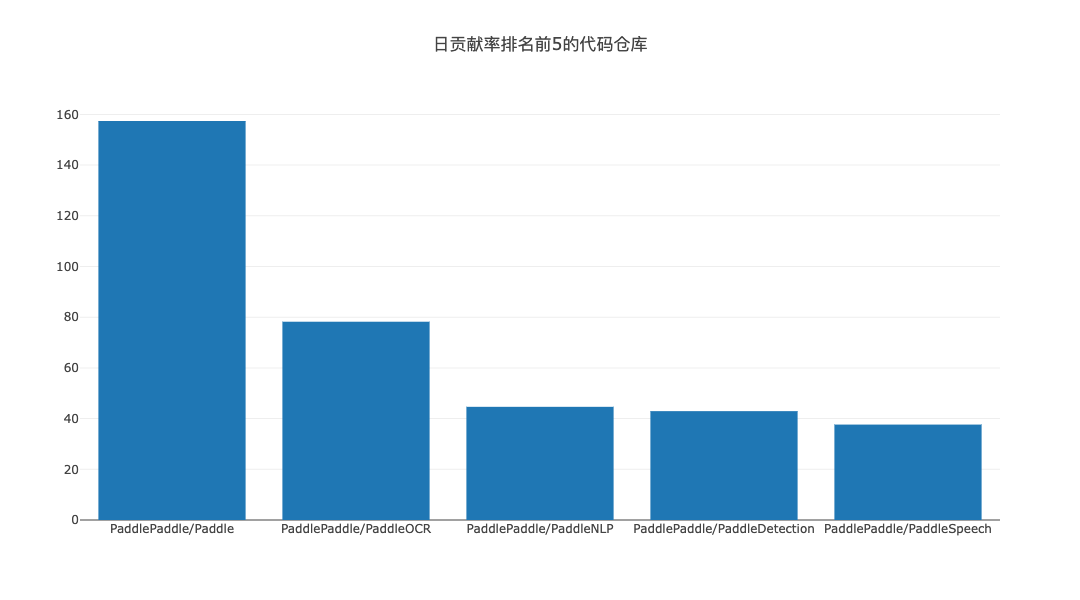

In [4]:
//查看日贡献率排名前5的代码仓库
query(    
    `
    select top 5 repo_name ,avg_contribute_cnt 
    from(
        select repo_name,dateDiff('day',min(created_at),max(created_at)) as daydiff,count()/ dateDiff('day',min(created_at),max(created_at)) as avg_contribute_cnt
         from github_log.events
         group by repo_name
         order by avg_contribute_cnt desc
     )
    where daydiff != '0'
    `
).then(data => {
    var repo_names=[],avg_contribute_cnts= [];
    data.forEach(d => {
        repo_names.push(d.repo_name);
        avg_contribute_cnts.push(d.avg_contribute_cnt);
    });

openDigger.render.plotly([
    {x: repo_names, y: avg_contribute_cnts,type:'bar', name: 'Average number of contributions'}], 
    {
        title: '日贡献率排名前5的代码仓库',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
});

通过计算每个代码仓库日平均参与量可以发现Paddle社区日常贡献排前五的项目有： 
1. Paddle
2. PaddleOCR
3. PaddleNLP
4. PaddleDetection
5. PaddleSpeech   

可以看出来 CV和NLP方向的项目还是更受欢迎的

### 1.2 使用语言

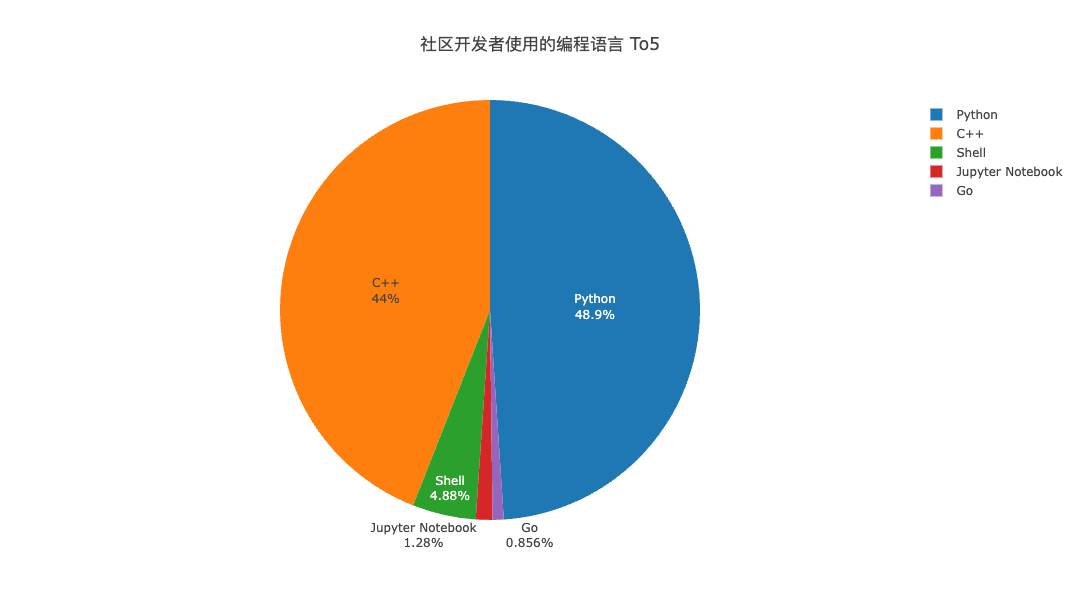

In [5]:
//社区开发者使用的编程语言 (统计repo_languages获得)
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != ''
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie', name: 'times', textinfo: "label+percent"}], 
    {
        title: '社区开发者使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
});

通过分析可以看到Paddle社区开发者主要使用的是Python和C++，两者使用占比之和超过了92%


### 1.3 活跃情况

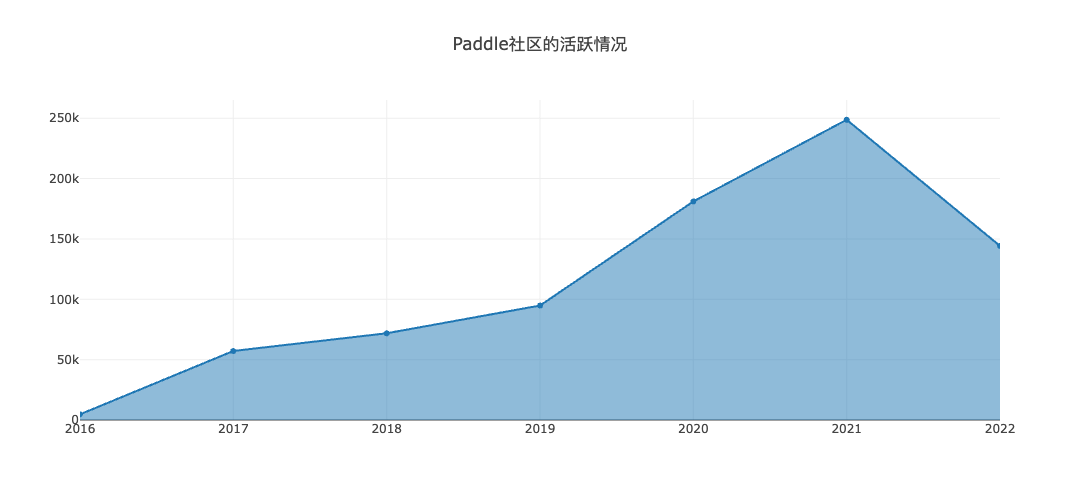

In [6]:
//分析Paddle社区的活跃情况
query(    
    `
     select toYear(created_at) as year,count() as total_times
     from github_log.events
     group by toYear(created_at)
     order by toYear(created_at)
    `
).then(data => {
    var years=[],total_times= [];
    data.forEach(d => {
        years.push(d.year);
        total_times.push(d.total_times);
    });

openDigger.render.plotly([
    {x: years, y: total_times, type: 'scatter',mode:'line', name: '数量', fill: 'tozeroy',}], 
    {
        title: 'Paddle社区的活跃情况',
        xaxis: {type: 'category'},
        height: 500,
        // width:900,
    });
});

通过统计每年的Github日志数量可以分析出来Paddle社区的活跃情况，可以看出来Paddle社区的活跃情况是逐年攀升的

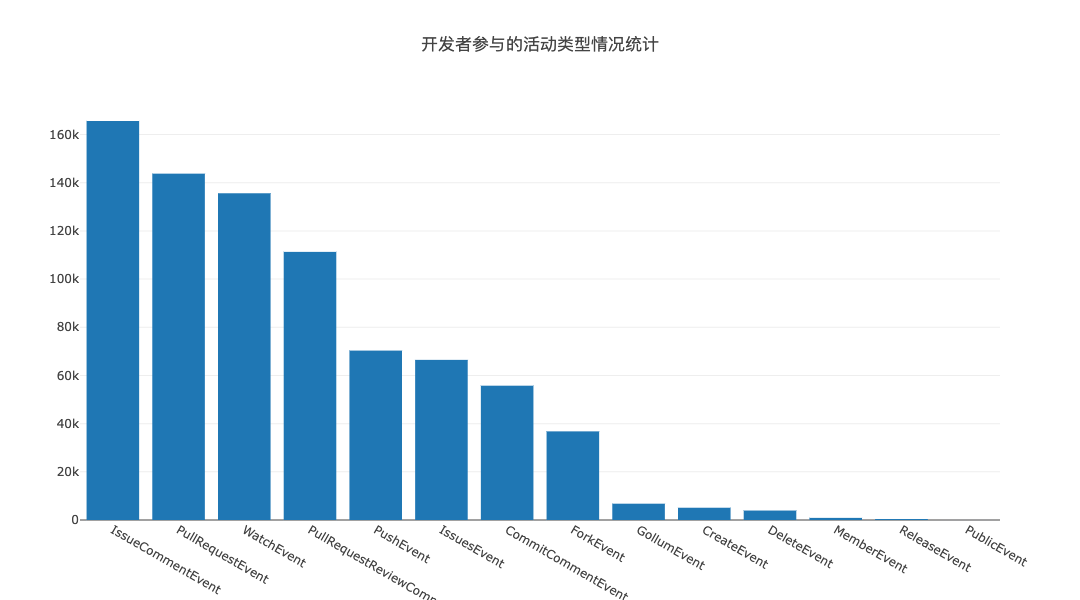

In [7]:
//开发者参与的活动类型情况统计（2016-2022年）
query(    
    `
     select type,count() as type_cnt
     from github_log.events
     group by type
     order by type_cnt desc
    `
).then(data => {
    var types=[],type_cnts=[];
    data.forEach(d => {
        types.push(d.type);
        type_cnts.push(d.type_cnt);
    });

openDigger.render.plotly([
    {x: types, y: type_cnts,type:'bar', name: '日志数量'}], 
    {
        title: '开发者参与的活动类型情况统计',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
});

通过对开发者参与的活动进行统计分析可以看出开发者主要是参与包括IssueCommentEvent、PullRequesEvent、WatchEvent、PullRequesReviewCommentEvent、PushEvent等

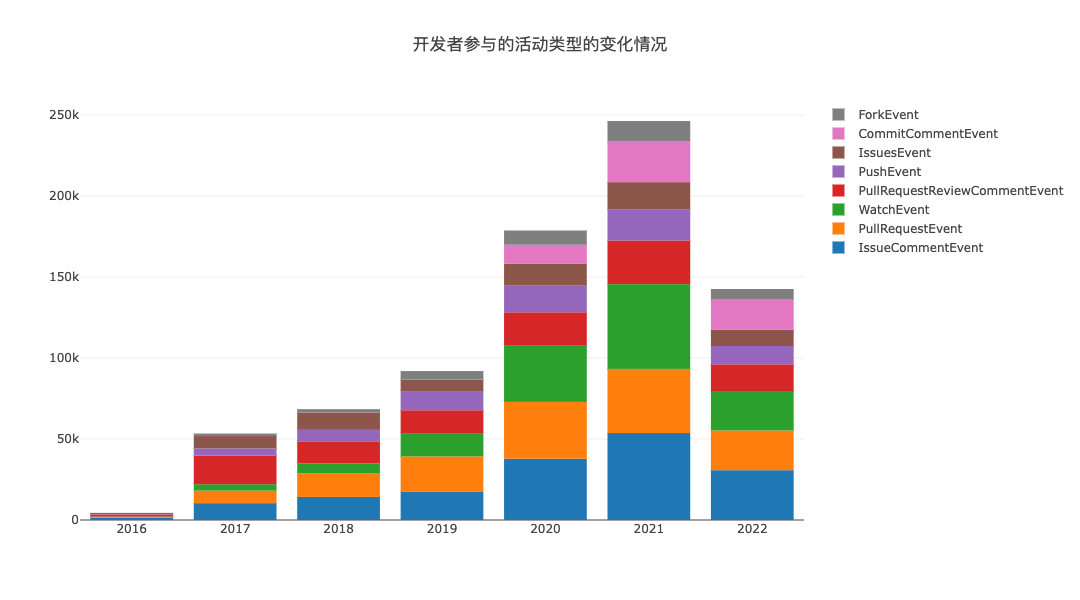

In [8]:
//开发者参与的活动类型的变化情况
query(    
    `select toYear(created_at) as year,type,count() as cnt
     from github_log.events
     where type in ['IssueCommentEvent','PullRequestEvent','WatchEvent','PullRequestReviewCommentEvent','PushEvent','IssuesEvent','CommitCommentEvent','ForkEvent']
     group by type,year
     order by year
    `
).then(data => {
    var types=['IssueCommentEvent','PullRequestEvent','WatchEvent','PullRequestReviewCommentEvent','PushEvent','IssuesEvent','CommitCommentEvent','ForkEvent'];
    var IssueCommentEvent_cnts=[],PullRequestEvent_cnts=[],WatchEvent_cnts=[],PullRequestReviewCommentEvent_cnts=[],
        PushEvent_cnts=[],IssuesEvent_cnts=[],CommitCommentEvent_cnts=[],ForkEvent_cnts=[];
    var years=[2016, 2017, 2018,2019,2020,2021,2022];
    data.forEach(d => {
        if(d.type == 'IssueCommentEvent')
            IssueCommentEvent_cnts.push(d.cnt);
        else if(d.type == 'PullRequestEvent')
            PullRequestEvent_cnts.push(d.cnt);
        else if(d.type == 'WatchEvent')
            WatchEvent_cnts.push(d.cnt);
        else if(d.type == 'PullRequestReviewCommentEvent')
            PullRequestReviewCommentEvent_cnts.push(d.cnt);
        else if(d.type == 'PushEvent')
            PushEvent_cnts.push(d.cnt);
        else if(d.type == 'IssuesEvent')
            IssuesEvent_cnts.push(d.cnt);
        else if(d.type == 'CommitCommentEvent')
            CommitCommentEvent_cnts.push(d.cnt);
        else
            ForkEvent_cnts.push(d.cnt);
    });
    
    var trace1 = {
      x: years,
      y: IssueCommentEvent_cnts,
      name: 'IssueCommentEvent',
      type: 'bar'
    };

    var trace2 = {
      x: years,
      y: PullRequestEvent_cnts,
      name: 'PullRequestEvent',
      type: 'bar'
    };
    var trace3 = {
      x: years,
      y: WatchEvent_cnts,
      name: 'WatchEvent',
      type: 'bar'
    };
    var trace4 = {
      x: years,
      y: PullRequestReviewCommentEvent_cnts,
      name: 'PullRequestReviewCommentEvent',
      type: 'bar'
    };
    var trace5 = {
      x: years,
      y: PushEvent_cnts,
      name: 'PushEvent',
      type: 'bar'
    };
    var trace6 = {
      x: years,
      y: IssuesEvent_cnts,
      name: 'IssuesEvent',
      type: 'bar'
    };
    var trace7 = {
      x: years,
      y: CommitCommentEvent_cnts,
      name: 'CommitCommentEvent',
      type: 'bar'
    };
    var trace8 = {
      x: years,
      y: ForkEvent_cnts,
      name: 'ForkEvent',
      type: 'bar'
    };
    
    var data = [trace1, trace2,trace3,trace4,trace5,trace6,trace7,trace8];

    var layout = {
        title: '开发者参与的活动类型的变化情况',
        barmode: 'stack',
        height: 600,
    };

openDigger.render.plotly(data,layout);
});


通过分析IssueCommentEvent、PullRequestEvent、WatchEvent、PullRequestReviewCommentEvent、PushEvent、IssuesEvent、
CommitCommentEvent、ForkEvent每年的变化可以发现这些活动每年都保持着增长

### 1.4 Paddle 社区的活跃周期

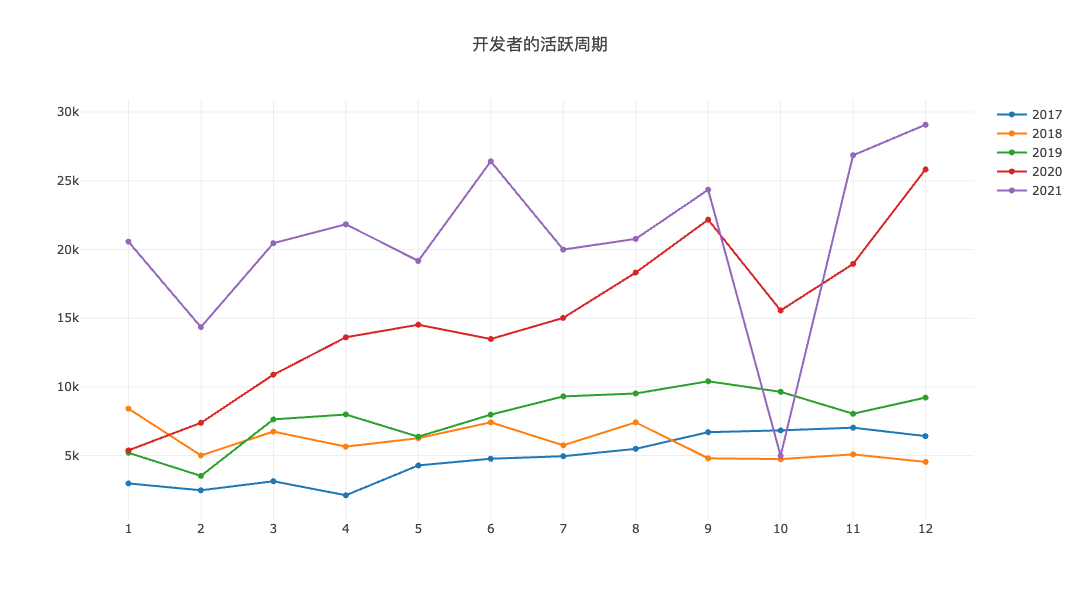

In [9]:
//分析开发者的活跃周期
query(    
    `
     select toYear(created_at) as year,toMonth(created_at) as month,count() as times
     from github_log.events
     group by year,month
     order by year,month
    `
).then(data => {
    var months=[1,2,3,4,5,6,7,8,9,10,11,12];
    var month_2016 = [],month_2017 = [],month_2018 = [],month_2019 = [],month_2020 = [],month_2021 = [],month_2022 = [];
    var times_2016 = [],times_2017 = [],times_2018 = [],times_2019 = [],times_2020 = [],times_2021 = [],times_2022 = [];
    data.forEach(d => {
        if(d.year == 2016){
            month_2016.push(d.month);
            times_2016.push(d.times);
        }
        else if(d.year==2017){
            month_2017.push(d.month);
            times_2017.push(d.times);
        }
        else if(d.year==2018){
            month_2018.push(d.month);
            times_2018.push(d.times);
        }
        else if(d.year==2019){
            month_2019.push(d.month);
            times_2019.push(d.times);
        }
        else if(d.year==2020){
            month_2020.push(d.month);
            times_2020.push(d.times);
        }
        else if(d.year==2021){
            month_2021.push(d.month);
            times_2021.push(d.times);
        }
        else if(d.year==2022){
            month_2022.push(d.month);
            times_2022.push(d.times);
        }
    });

openDigger.render.plotly([
    {x: month_2017, y: times_2017, type: 'scatter',mode:'line', name: '2017'},
    {x: month_2018, y: times_2018, type: 'scatter',mode:'line', name: '2018'},
    {x: month_2019, y: times_2019, type: 'scatter',mode:'line', name: '2019'},
    {x: month_2020, y: times_2020, type: 'scatter',mode:'line', name: '2020'},
    {x: month_2021, y: times_2021, type: 'scatter',mode:'line', name: '2021'},
    //{x: month_2022, y: times_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: '开发者的活跃周期',
        xaxis: {type: 'category'},
        height: 600,
    });
});

通过统计每年的月活动数量来分析开发者的活跃周期，多数情况每年的1、2月份，社区活动次数都会减少，这应该是中国春节假期导致的。而这几年，Paddle社区在7、8、9月份的活动次数在增加，推测原因可能是Paddle社区最近几年推动高校学生来参与开源项目，而这个时间点刚好是学生放暑假的时间，所以时间会比较多。而2021年2、10月份社区的活动次数下降较为明显

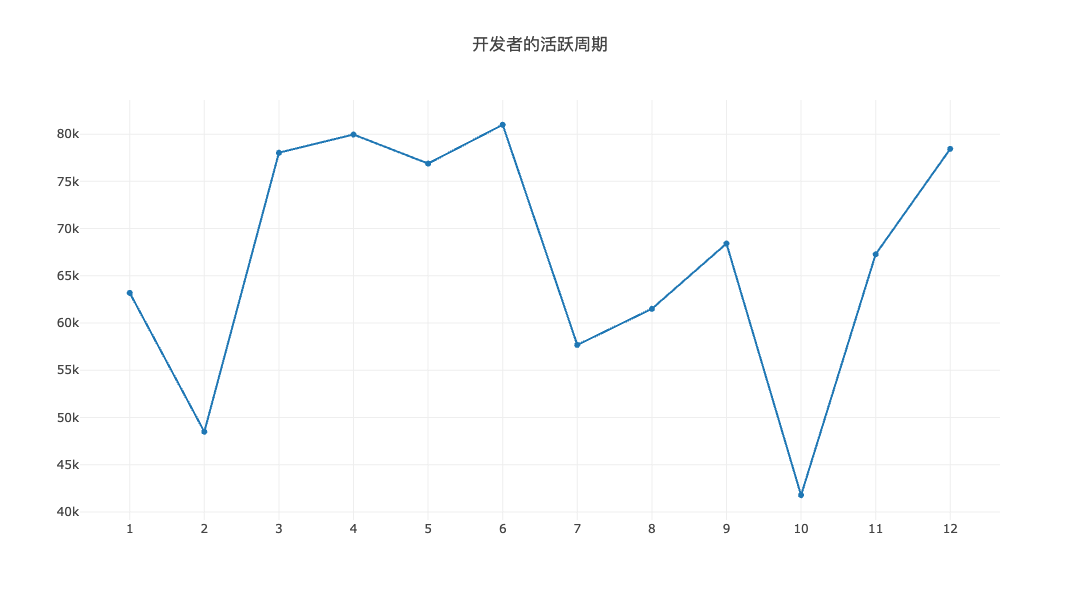

In [10]:
//分析开发者的活跃周期
query(    
    `
     select toMonth(created_at) as month,count() as times
     from github_log.events
     group by month
     order by month
    `
).then(data => {
    var months=[];
    var times= []
    data.forEach(d => {
            months.push(d.month);
            times.push(d.times);
    });

openDigger.render.plotly([
    {x: months, y: times, type: 'scatter',mode:'line', name: '2017'}
    ], 
    {
        title: '开发者的活跃周期',
        xaxis: {type: 'category'},
        height: 600,
    });
});

我们将所有的数据按照月进行分组统计，可以看到Paddle社区在2、7、10月份有明显的下降，而在7-9、10-12有明显的上升趋势

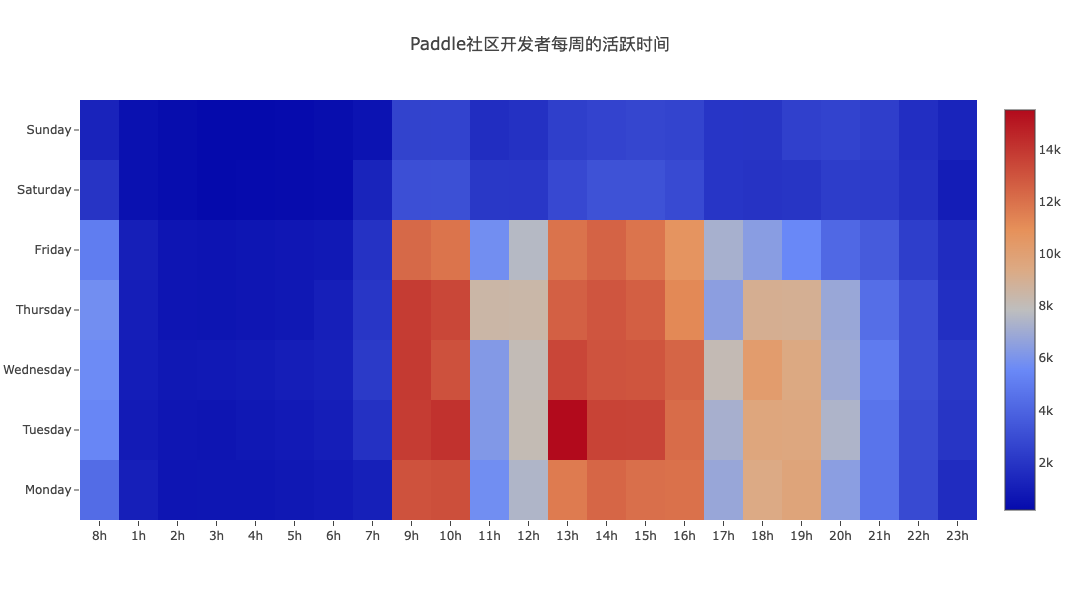

In [11]:
//统计社区开发者每周的活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(toHour(created_at)+7)%24 as hour,count() as times
     from github_log.events
     --where type='IssuesEvent'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['8h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: 'Paddle社区开发者每周的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
        width:1050,
    });
});


通过绘制Paddle社区开发者每周的活跃时间热力图，我们可以轻松的看出来Paddle社区不是996的项目，周六日社区开发者的活动次数明显下降。开发者的活跃时间主要集中在工作日，周一到周五。一般Paddle社区的开发者是从早上8点开始工作，中午11点到12点会进行休息，在下午1点又开始投入工作，一直持续到下午5点，下午5点到6点会进行短暂地休息后又继续工作到晚上8点，较符合一般的工作时间情况

## 2.Paddle社区开发者画像分析

下面的主要分析工作我是利用python来实现的，具体代码实现在[Paddle社区开发者画像分析]("https://github.com/longranger2/Open-Source-Community-Insights/blob/main/paddle/Paddle%E7%A4%BE%E5%8C%BA%E5%BC%80%E5%8F%91%E8%80%85%E7%94%BB%E5%83%8F%E5%88%86%E6%9E%90.ipynb")这个Jupyter上

### 2.1 开发者的技能标签

![jupyter](https://raw.githubusercontent.com/longranger2/Open-Source-Community-Insights/main/paddle/Developer%20Skills%20Word%20Cloud.png)

我利用TFIDF算法对Github日志数据对body字段进行关键词提取，然后对提取后的开发者技能关键词进行词频统计后利用[微词云](https://www.weiciyun.com/)网站生成词云。可以看到社区的开发者的技能主要是围绕深度学习方向的

### 2.2 所在组织

根据字段push_commits.email邮箱后缀去分析其所在的组织，但通过对邮箱进行统计分析后发现很多都是个人邮箱，无法准确判定其所在的组织，只能大概分析下Paddle社区开发者的都来自哪些组织

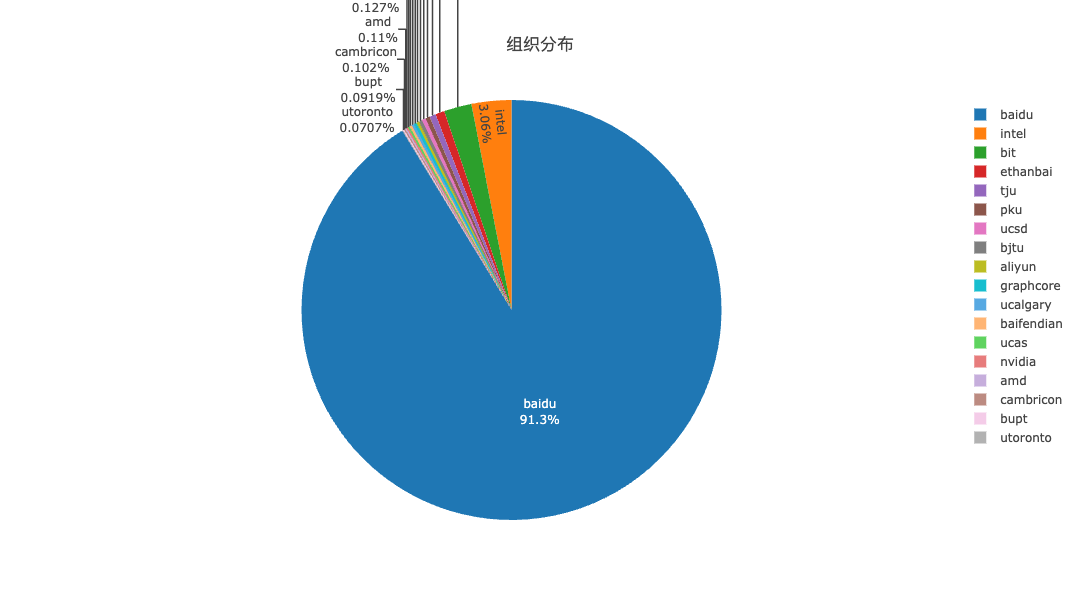

In [13]:
//开发者参与的活动类型情况统计（2016-2022年）
query(    
    `
    select count()
    FROM github_log.events
    `
).then(data => {
    var organizations=['baidu','intel','bit','ethanbai','tju','pku','ucsd','bjtu','aliyun','graphcore','ucalgary','baifendian','ucas','nvidia','amd','cambricon','bupt','utoronto'];
    var cnts=[25834,867,603,199,136,94,85,74,59,59,56,52,41,36,31,29,26,20];
    
openDigger.render.plotly([
    {labels: organizations, values: cnts,type:'pie', name: '数量', textinfo: "label+percent"}], 
    {
        title: '组织分布',
        xaxis: {type: 'category'},
        height:600,
        //width: 1050,
        //margin: {"t":50 , "b": 0, "l": 100, "r": 0},
    });
});

可以看到Paddle社区的组织主要是百度为主，还有诸如Intel、阿里巴巴、nvida等公司

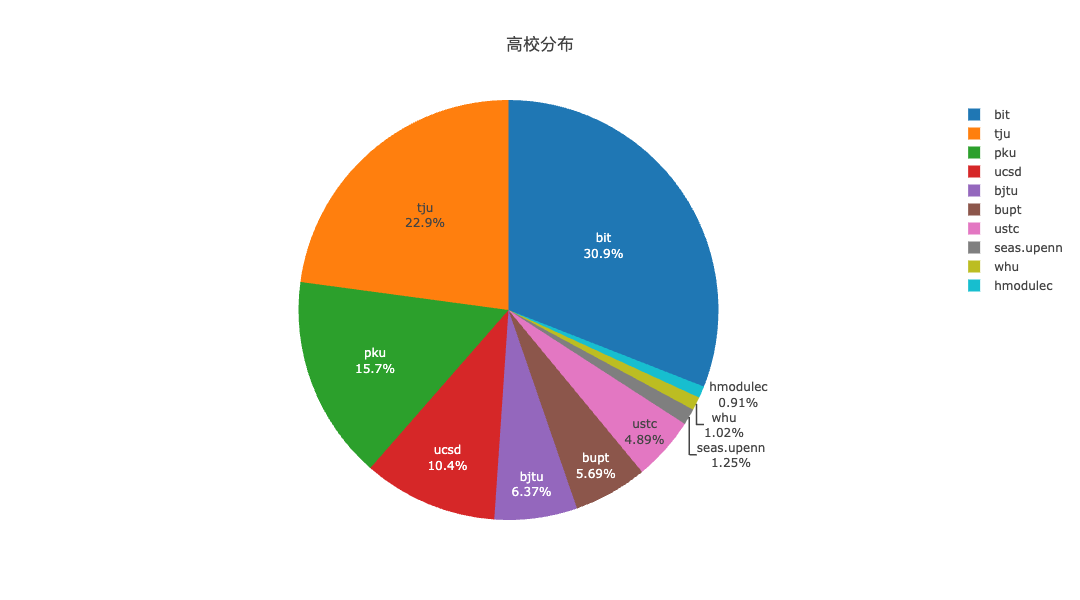

In [14]:
//高校分布
query(`
    select count()
    FROM github_log.events

`).then(data => {
    var universities=['bit','tju','pku','ucsd','bjtu','bupt','ustc','seas.upenn','whu','hmodulec'];
    var cnts=[272,201,138,91,56,50,43,11,9,8,7,7,6,5,4,1];
openDigger.render.plotly([
    {labels: universities, values: cnts,type:'pie', name: '数量', textinfo: "label+percent"}], 
    {
        title: '高校分布',
        xaxis: {type: 'category'},
        height: 600,
//        margin: {"t":100 , "b": 80, "l": 100, "r": 100},
        //pad:{"t":100 , "b": 80, "l": 100000000000, "r": 0}
    });
});

然后我通过分析”edu"的后缀来看看有哪些高校开发者参与了Paddle社区建设，这里我只选取前人数最多的前十个高校，可以看到排前三的高校分别是北京理工大学、天津大学、北京大学

### 2.3 所在时区分析

参考这篇文章：http://oss.x-lab.info/github-insight-report-2020.pdf  
逻辑就是根据开发者全年每小时产生日志的数量，计算获取其最多的连续12个小时，令其时间为该开发者本地时间的9时至21时，则可以大致确定该开发者的所属时区

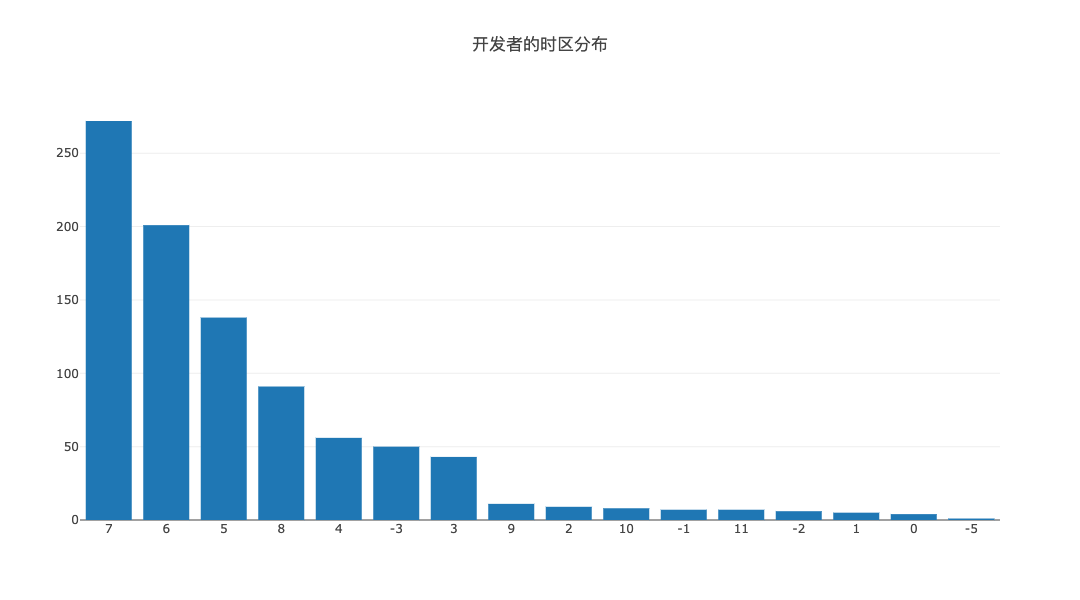

In [15]:
//开发者的时区分布
query(`
    select count()
    FROM github_log.events

`).then(data => {
    var zones=[7,6,5,8,4,-3,3,9,2,10,-1,11,-2,1,0,-5];
    var cnts=[272,201,138,91,56,50,43,11,9,8,7,7,6,5,4,1];
openDigger.render.plotly([
    // {labels: zones, values: cnts,type:'pie', name: '数量'}], 
    {x: zones, y: cnts,type:'bar', name: '数量',fill: 'rgb(142,124,195)'}], 
    {
        title: '开发者的时区分布',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
});

可以看到Paddle社区多数开发者主要是集中在时区7

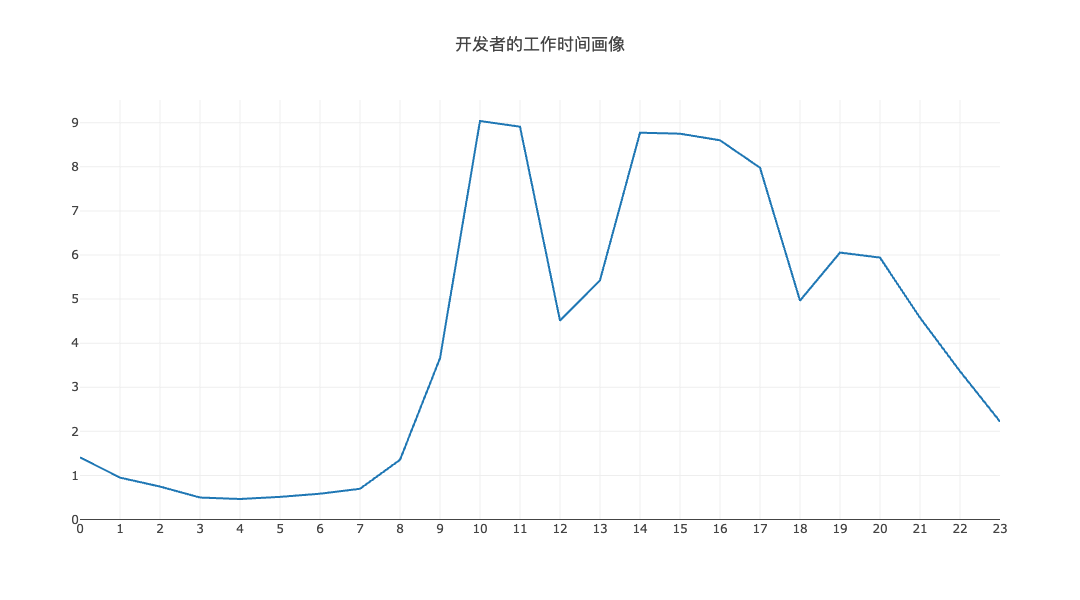

In [15]:
//开发者一天的工作时间画像
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
    ) AS total_times
     select (toHour(created_at)+8) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者的工作时间画像',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
});

从上图不难看出，一般开发者会选择从当地时间早上8点开始工作，中午11-13进行短暂的午休，随后14-16点达到一个生产高峰并持续产出到晚间，较符合一般的工作时间情况，但可以看到开发者在晚间的工作产出比例还是比较高的，设置可以工作到凌晨1-2点，活跃程度应该明显高于一般职业

### 2.3 选取10位典型开发者展开介绍，形成对Paddle社区开发者的具象认知。

为了让大家形成对飞桨社区开发者的具象认知，我利用影响力指标筛选出飞桨社区影响力最大的10名开发者，而影响力的评价指标定义如下： 

$$影响力=0.1\times 发布issue的数量+0.2\times 发布评论的数量+0.35 \times PR的数量+0.35\times PR_Riview的数量$$

In [16]:
//构建评价指标体系，选出影响力最大的前10名开发者
query(    
    `
    select actor_login, round((0.1*Issue_cnt/66462+0.2*Issue_Comment_cnt/165610+0.35*PR_cnt/143755+0.35*PR_ReviewComment_cnt/111286)*100,3) as Index
    from 
    (
        SELECT actor_login,SUM( CASE WHEN type = 'IssuesEvent' THEN 1 ELSE 0 END ) AS Issue_cnt,
        SUM(CASE WHEN type = 'IssueCommentEvent' THEN 1 ELSE 0 END ) AS Issue_Comment_cnt,
        SUM(CASE WHEN type='PullRequestEvent' THEN 1 ELSE 0 END) as PR_cnt,
        sum(CASE WHEN type='PullRequestReviewCommentEvent' THEN 1 ELSE 0 END) as PR_ReviewComment_cnt
        from github_log.events 
        where actor_login !='paddle-bot[bot]'
        group by actor_login 
    )
    order by Index desc
    limit 10
    `
).then(console.table)

┌─────────┬──────────────────────┬───────┐
│ (index) │     actor_login      │ Index │
├─────────┼──────────────────────┼───────┤
│    0    │      'luotao1'       │ 2.555 │
│    1    │     'qingqing01'     │ 2.143 │
│    2    │      'reyoung'       │ 1.248 │
│    3    │       'Xreki'        │ 1.111 │
│    4    │      'chenwhql'      │ 1.106 │
│    5    │    'typhoonzero'     │ 1.097 │
│    6    │     'TCChenlong'     │ 0.981 │
│    7    │     'gongweibao'     │ 0.938 │
│    8    │ 'littletomatodonkey' │ 0.926 │
│    9    │     'wangkuiyi'      │ 0.899 │
└─────────┴──────────────────────┴───────┘


通过影响力这个评价指标筛选出Paddle社区影响力排前10的开发者，接下来将从其参与的社区活动、使用的常用编程语言、一天的工作时间展开来进行介绍，来对Paddle社区的开发者形成具象认知

#### 2.3.1 开发者luotao1

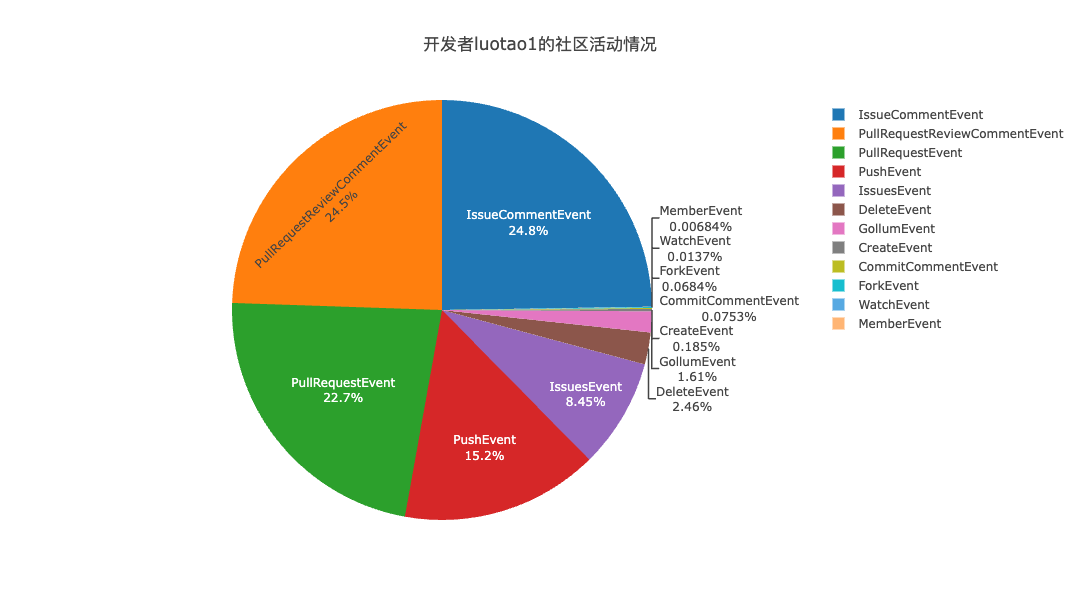

In [17]:
//issue数量、issue_comment、PR、PR_ReviewComment的占比
query(    
    `
        select type,count() as cnt
        from github_log.events 
        where actor_login = 'luotao1'
        --where actor_login = 'luotao1' and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewCommentEvent')
        group by type 
    `
).then(data => {
    var types=[],cnts= [];
    data.forEach(d => {
        types.push(d.type);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: types, values: cnts, type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者luotao1的社区活动情况',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
});

开发者luotao1主要参与的活动是IssueComment、PullRequestReviewComment，两者之和接近50%，说明其目前的定位是社区的维护者，帮助其他开发者进行答疑和代码核查

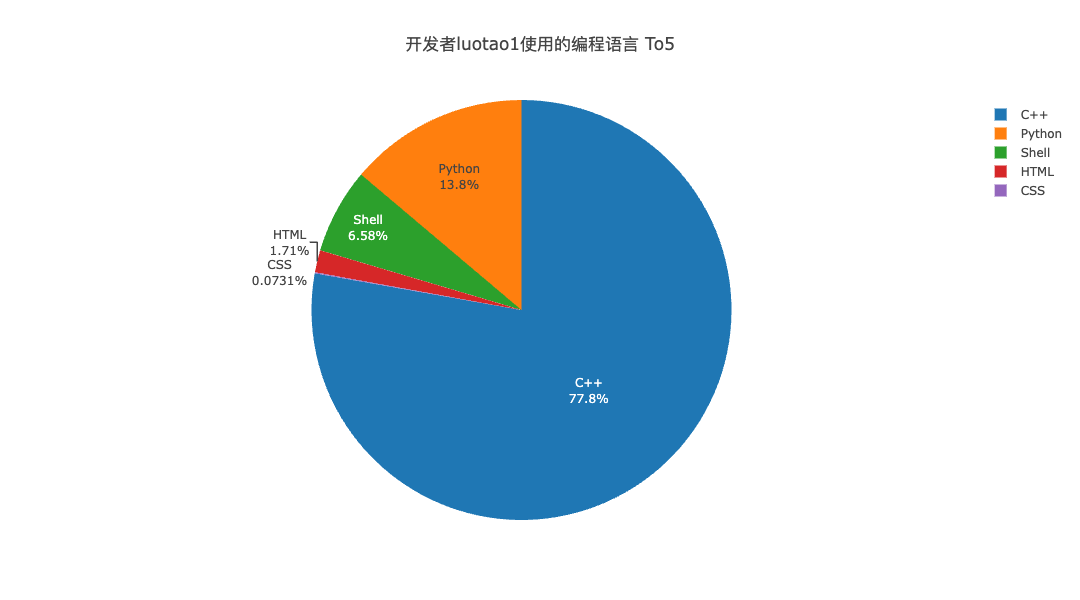

In [18]:
//使用的编程语言
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != '' and actor_login = 'luotao1'
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者luotao1使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
    });
});

可以看到开发者luotao1习惯的编程语言是C++，其次是Python

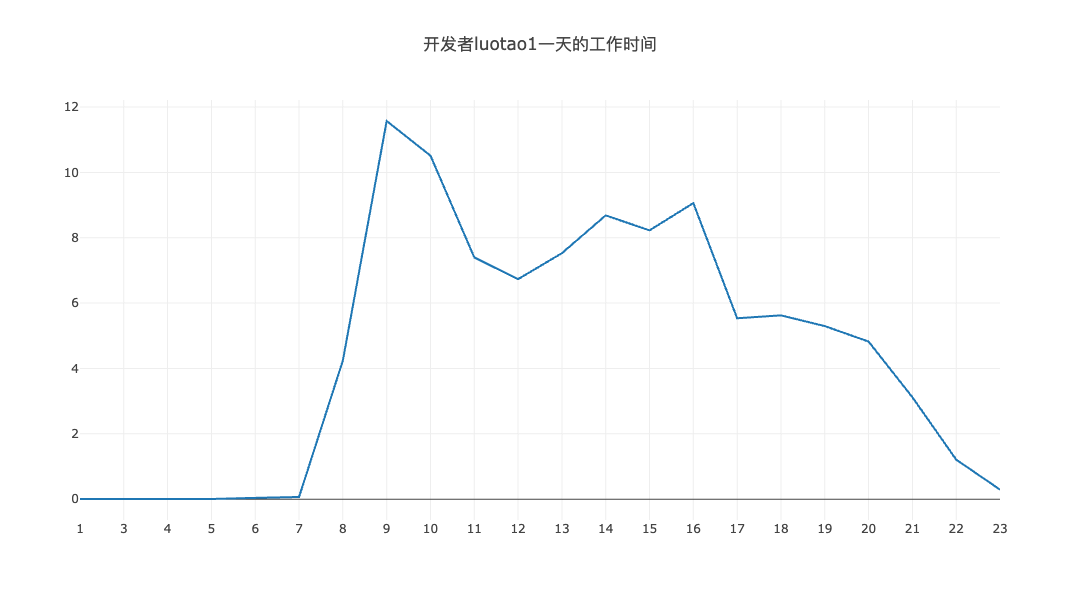

In [19]:
//工作时间（'luotao1'所在的时区为7）
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
        where actor_login = 'luotao1'
    ) AS total_times
     select (toHour(created_at)+7) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events 
     where actor_login = 'luotao1'
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者luotao1一天的工作时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者luotao1早上8点开始工作，在9点工作量达到一天的高峰，随之9-11点逐渐回落，在12-16点逐渐攀升，并在16点达到达到一个生产小高峰并又开始回落，晚上11点之后就没有进行任何活动了

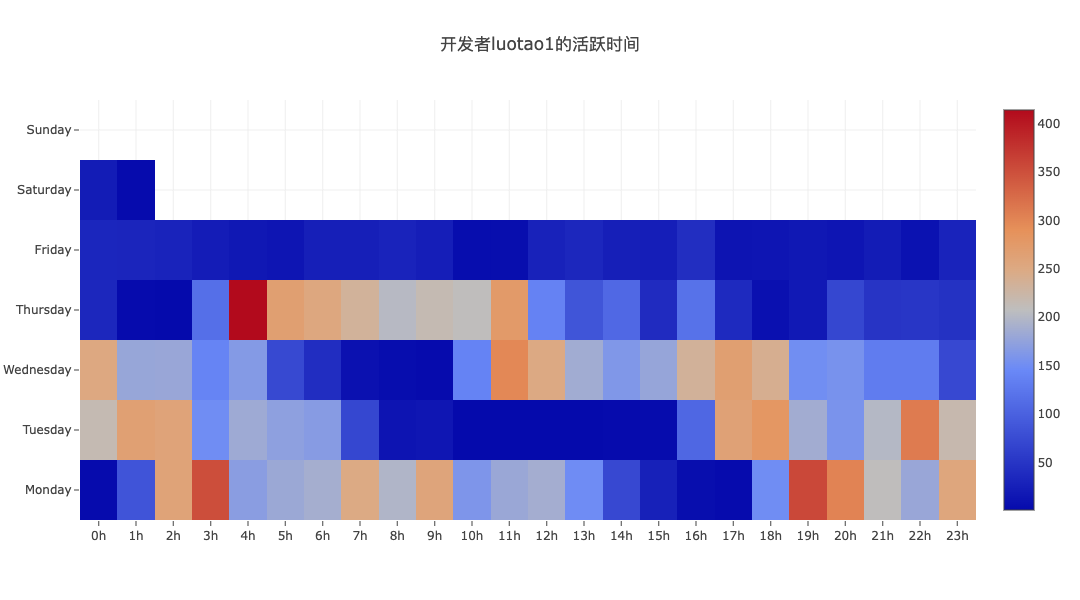

In [20]:
//活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(toHour(created_at)+7)%24 as hour,count() as times
     from github_log.events
     where actor_login = 'luotao1'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['0h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: '开发者luotao1的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者luotao1周六日是不进行工作的，一般只在工作日进行社区活动

#### 2.3.2 开发者qingqing01

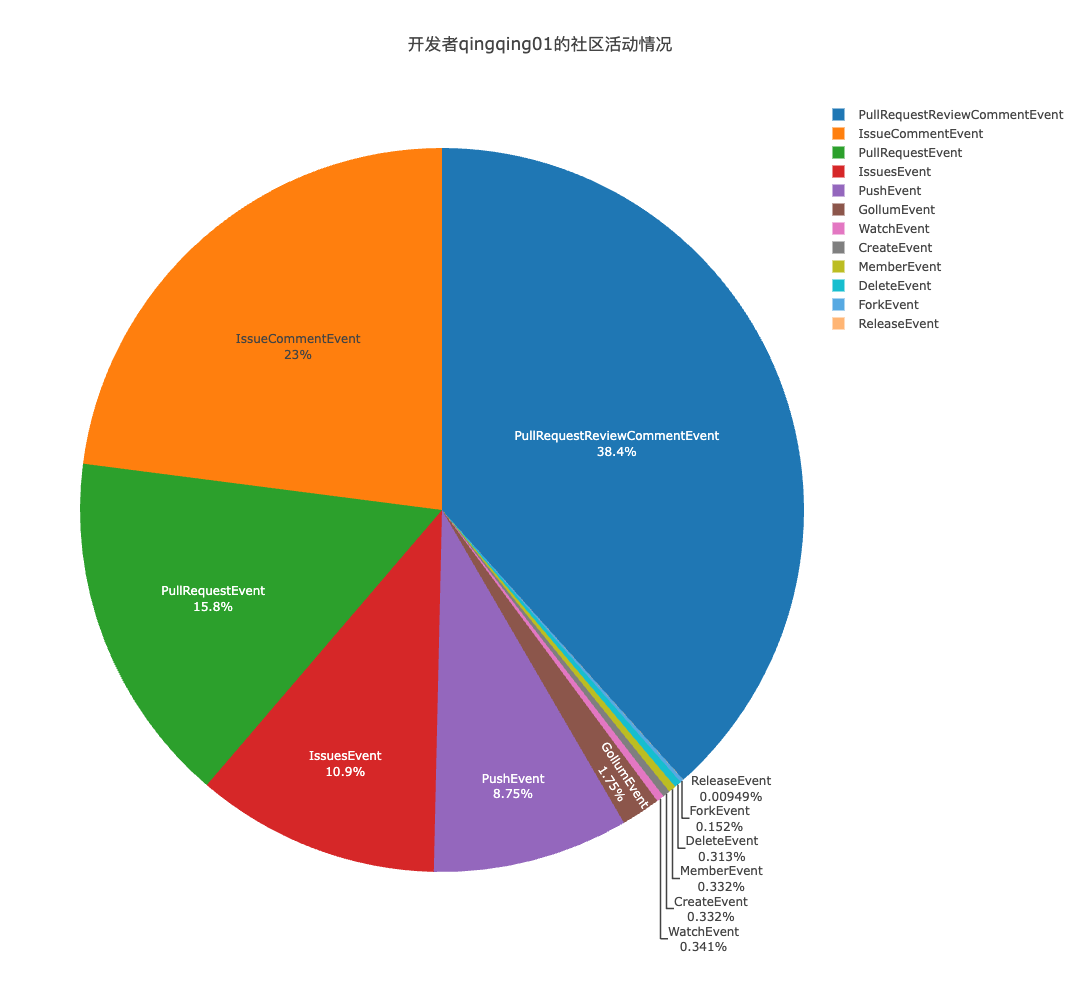

In [21]:
//issue数量、issue_comment、PR、PR_ReviewComment的占比
query(    
    `
        select type,count() as cnt
        from github_log.events 
        where actor_login = 'qingqing01'
        --where actor_login = 'qingqing01' and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewCommentEvent')
        group by type 
    `
).then(data => {
    var types=[],cnts= [];
    data.forEach(d => {
        types.push(d.type);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: types, values: cnts, type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者qingqing01的社区活动情况',
        xaxis: {type: 'category'},
        height: 1000,
    });
});

开发者qingqing01主要参与的活动是PullRequestReviewComment、IssueComment两者之和超过50%，说明其目前的定位是社区的维护者，帮助其他开发者进行答疑和代码核查

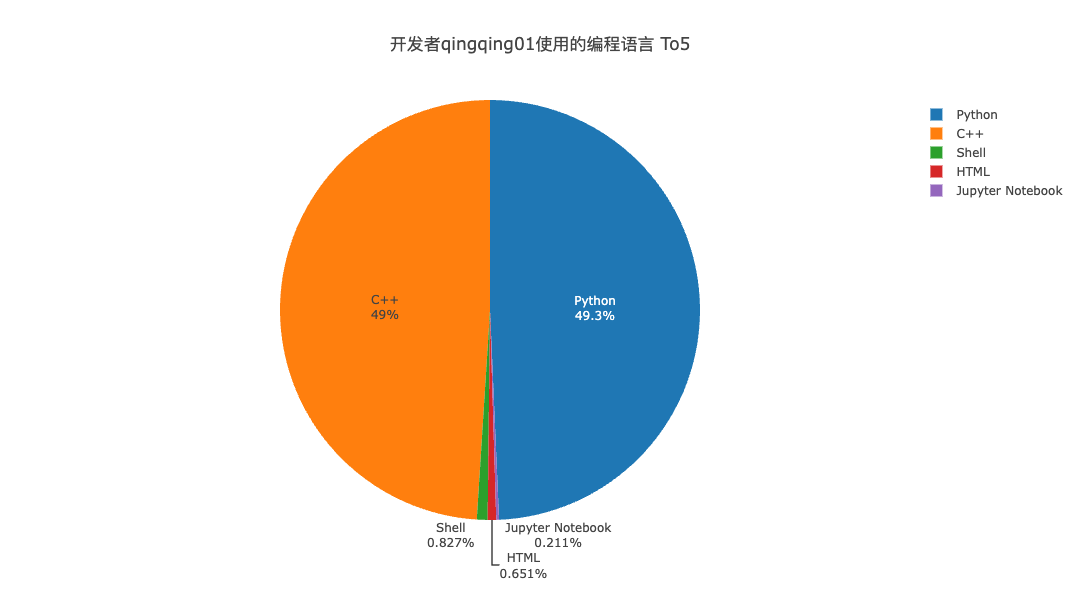

In [22]:
//使用的编程语言
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != '' and actor_login = 'qingqing01'
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者qingqing01使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者qingqing01习惯使用的编程语言主要是Python和C++，各占50%

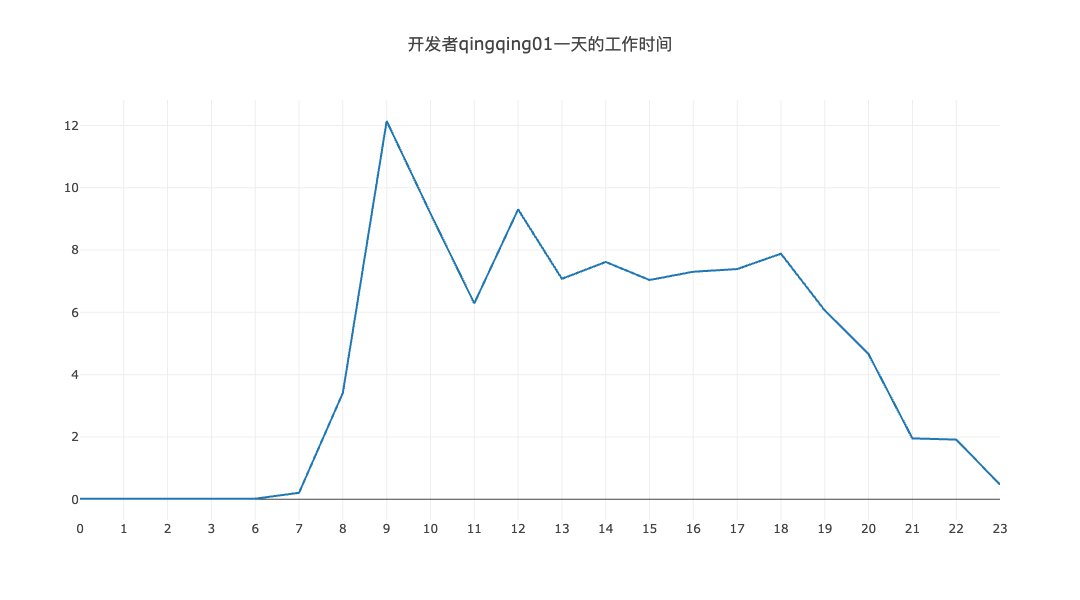

In [23]:
//工作时间（'qingqing01'所在的时区为7）
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
        where actor_login = 'qingqing01'
    ) AS total_times
     select (toHour(created_at)+7) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events 
     where actor_login = 'qingqing01'
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者qingqing01一天的工作时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者qingqing01从早上7点开始工作，在9点工作量达到一天的高峰，随之9-11点逐渐回落，在13-18点较为平稳，晚上11点之后就没有进行任何活动了

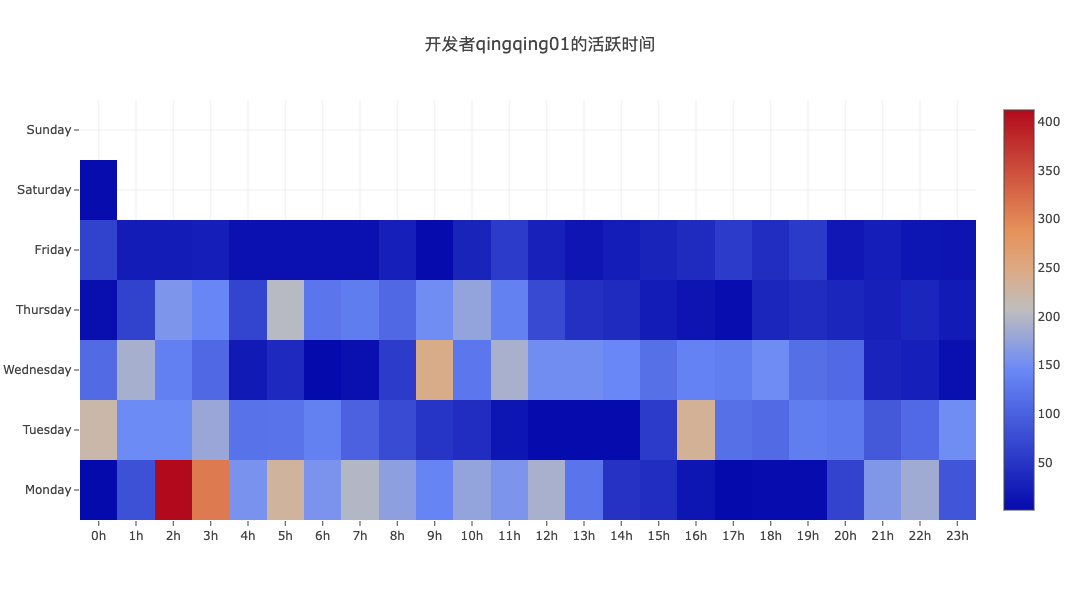

In [24]:
//活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(toHour(created_at)+7)%24 as hour,count() as times
     from github_log.events
     where actor_login = 'qingqing01'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['0h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: '开发者qingqing01的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者qingqing01周六日是不进行工作的，一般只在工作日进行社区活动

#### 2.3.3 开发者reyoung

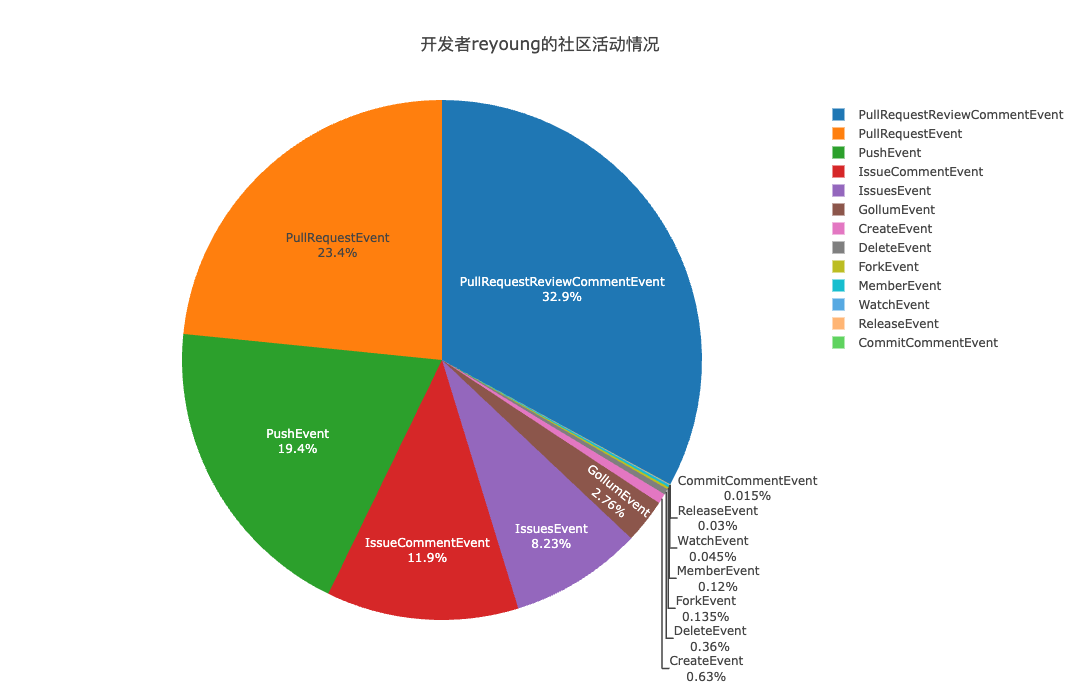

In [25]:
//issue数量、issue_comment、PR、PR_ReviewComment的占比
query(    
    `
        select type,count() as cnt
        from github_log.events 
        where actor_login = 'reyoung'
        --where actor_login = 'reyoung' and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewCommentEvent')
        group by type 
    `
).then(data => {
    var types=[],cnts= [];
    data.forEach(d => {
        types.push(d.type);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: types, values: cnts, type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者reyoung的社区活动情况',
        xaxis: {type: 'category'},
        height: 700,
    });
});

开发者reyoung的PullRequestReviewComment占比为32.9%、而PullRequest也有23.4%，说明其目前的定位是社区的维护者，帮助其他开发者进行代码核查，同时开发者reyoung自己也经常进行代码作业，积极提交PR

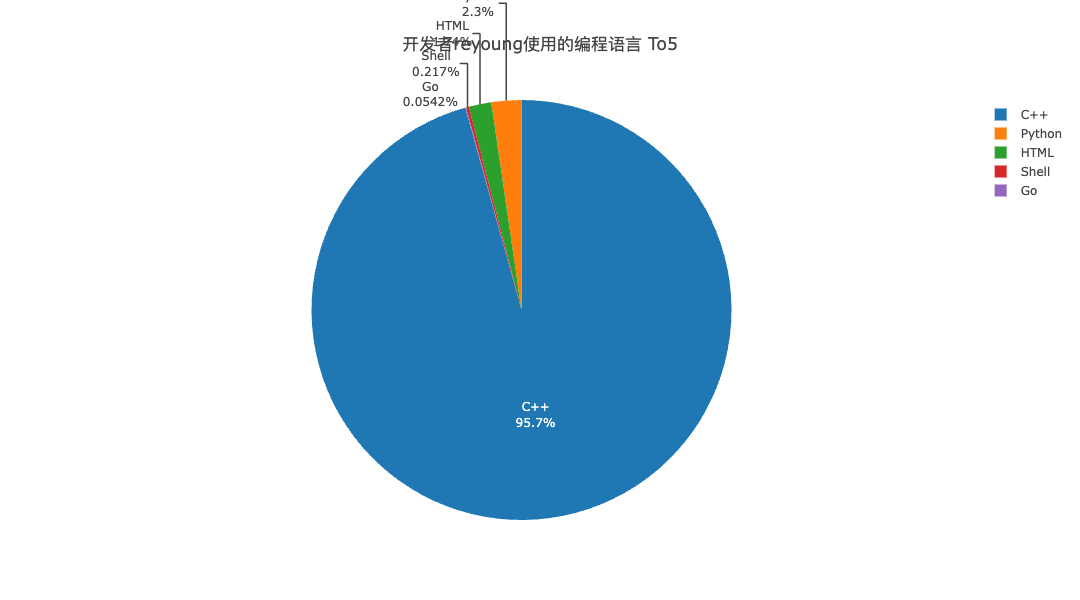

In [26]:
//使用的编程语言
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != '' and actor_login = 'reyoung'
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie',textinfo: "label+percent",}], 
    {
        title: '开发者reyoung使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
        //margin:{t:'100'}
    });
});

开发者reyoung主要使用C++

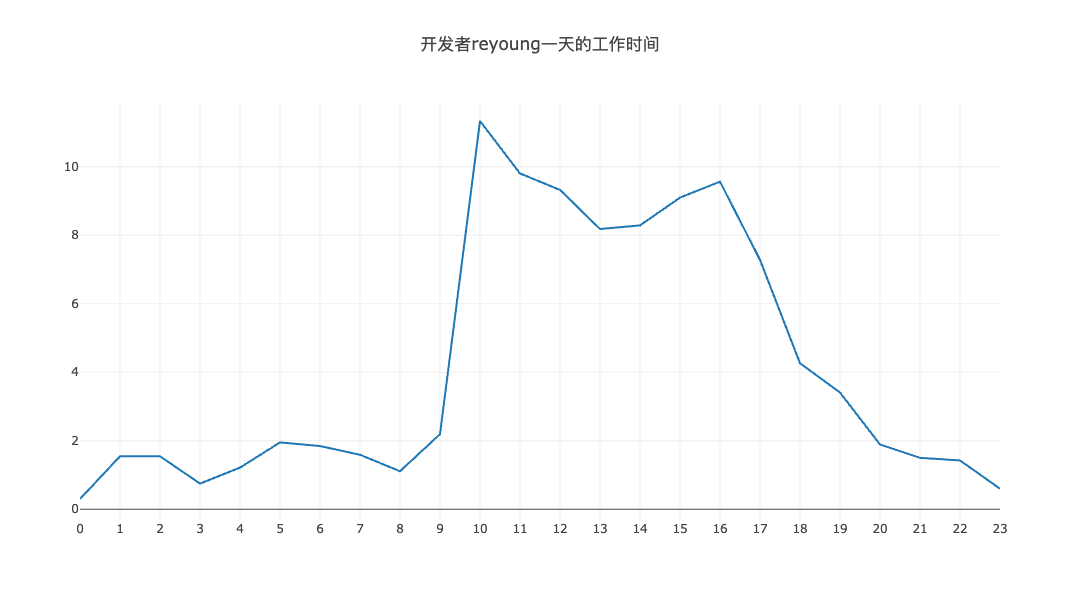

In [27]:
//工作时间（'reyoung'所在的时区为8）
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
        -- where actor_login = 'reyoung'
        where actor_id = 728699
    ) AS total_times
     select (toHour(created_at)+8) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events 
     -- where actor_login = 'reyoung'
     where actor_id = 728699
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者reyoung一天的工作时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者reyoung主要是活跃时间是9点到20点，在早上10点达到一天的最高峰，同时其他时间段都有进行过活动，且比例不低，说明该开发者也是个夜猫子

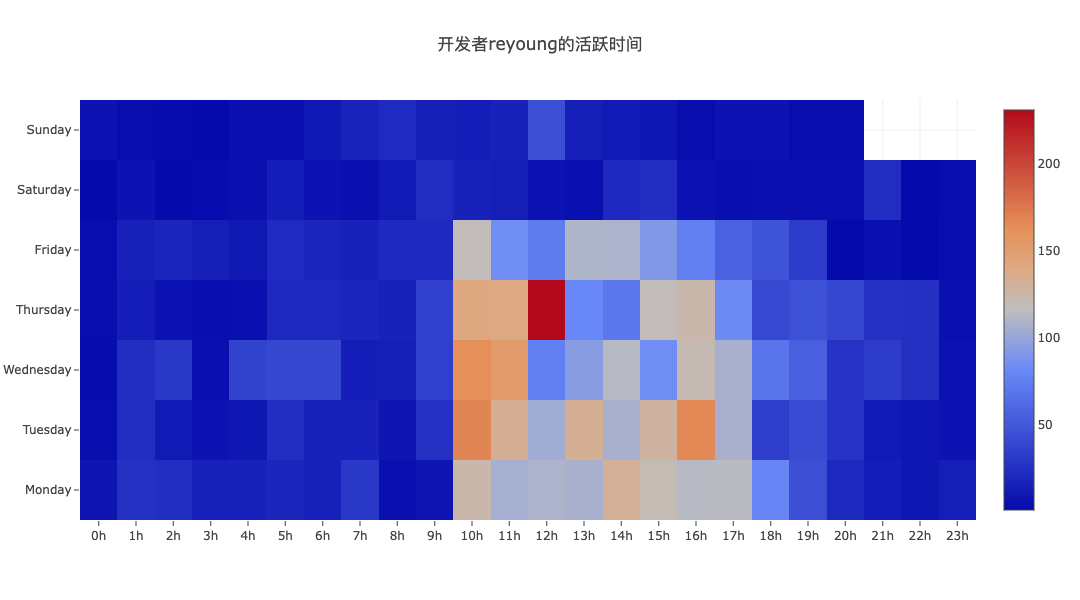

In [28]:
//活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(toHour(created_at)+8)%24 as hour,count() as times
     from github_log.events
     where actor_login = 'reyoung'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['0h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: '开发者reyoung的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

可以看到开发者reyoung是个热爱开源的开发者，在周六日都有进行社区活动，不过其主要活跃时间主要集中在工作日10点到17点

#### 2.3.4 开发者Xreki

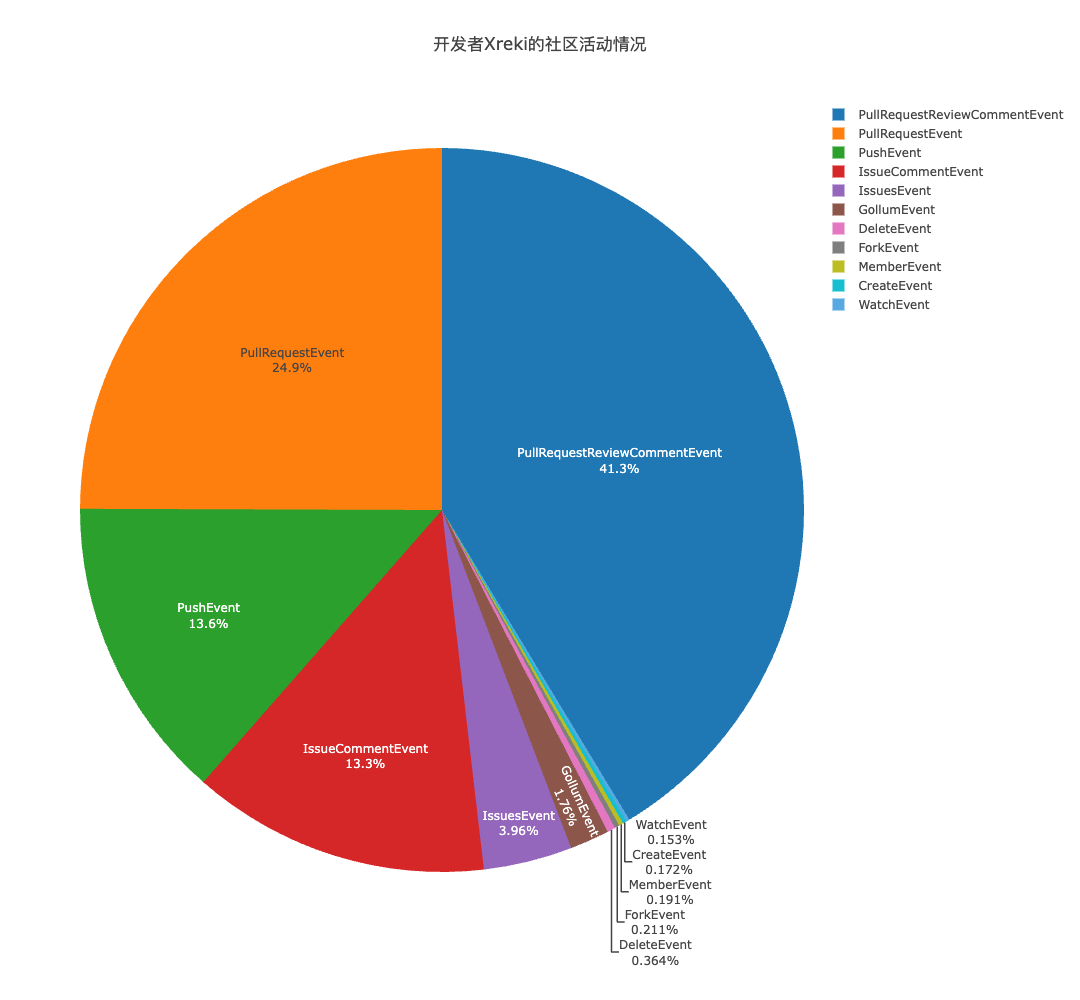

In [29]:
//issue数量、issue_comment、PR、PR_ReviewComment的占比
query(    
    `
        select type,count() as cnt
        from github_log.events 
        where actor_login = 'Xreki'
        --where actor_login = 'Xreki' and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewCommentEvent')
        group by type 
    `
).then(data => {
    var types=[],cnts= [];
    data.forEach(d => {
        types.push(d.type);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: types, values: cnts, type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者Xreki的社区活动情况',
        xaxis: {type: 'category'},
        height: 1000,
    });
});

开发者Xreki的PullRequestReviewComment占比为41.3%、而PullRequest也有接近25%，说明其目前的定位是社区的维护者，有接近一半的活动是在帮助其他开发者进行代码核查，同时开发者Xreki自己也经常进行代码作业，积极提交PR

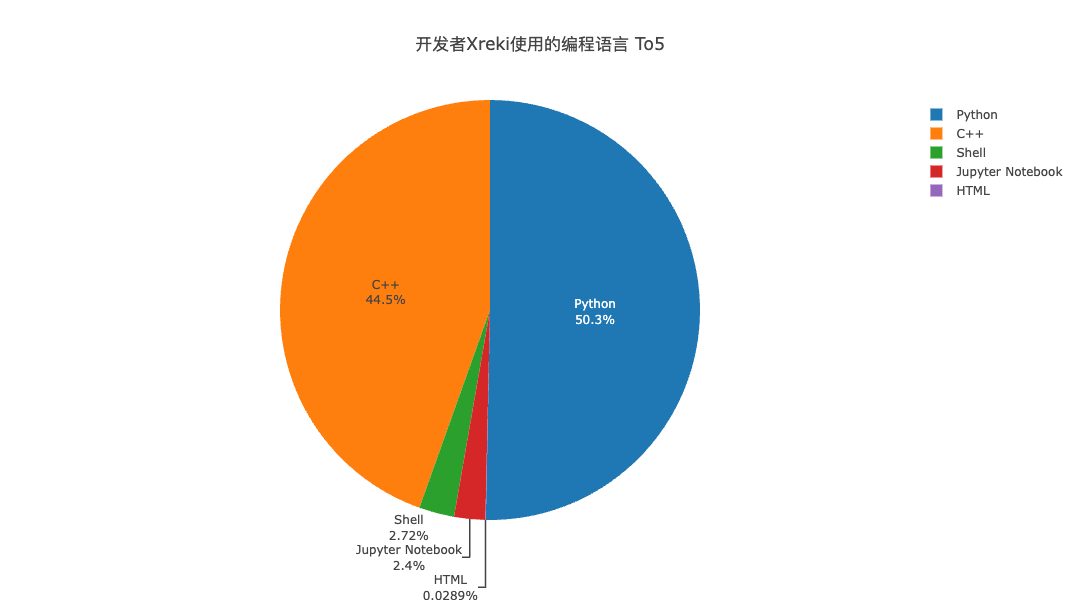

In [30]:
//使用的编程语言
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != '' and actor_login = 'Xreki'
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者Xreki使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者Xreki习惯使用的编程语言为Python和C++

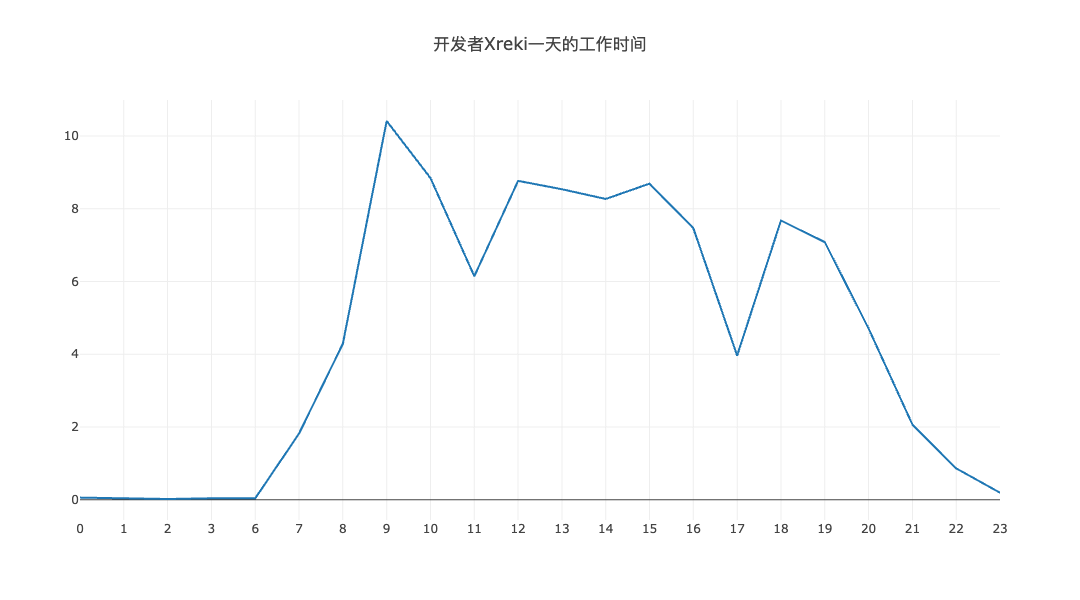

In [31]:
//工作时间（'Xreki'所在的时区为7）
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
        where actor_login = 'Xreki'
    ) AS total_times
     select (toHour(created_at)+7) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events 
     where actor_login = 'Xreki'
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者Xreki一天的工作时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者Xreki的主要工作时间是从早上7点到晚上9点，在早上9点达到一天的高峰

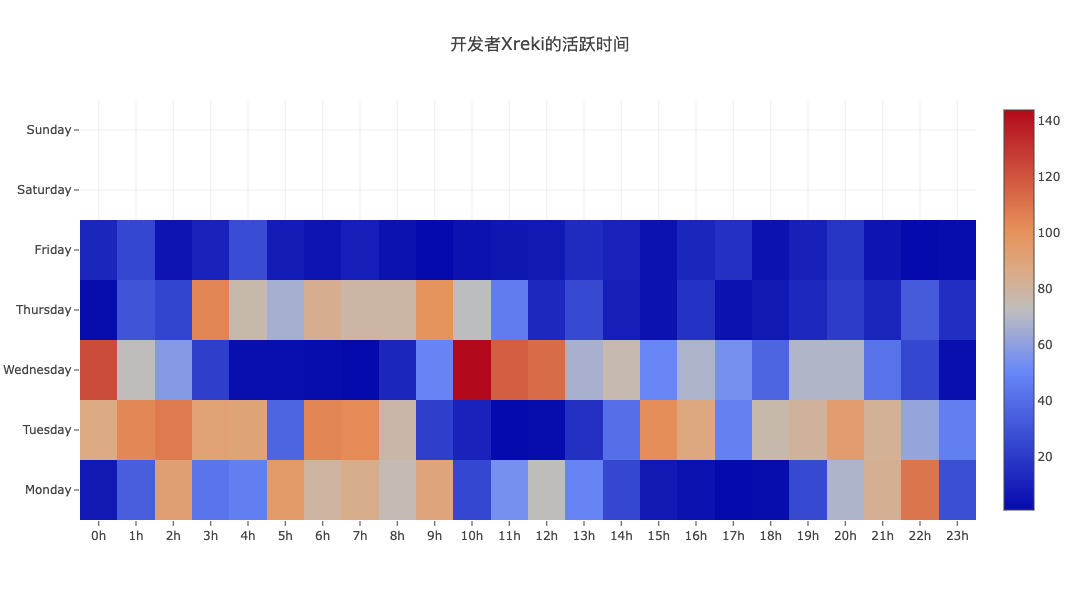

In [32]:
//活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(toHour(created_at)+7)%24 as hour,count() as times
     from github_log.events
     where actor_login = 'Xreki'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['0h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: '开发者Xreki的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者Xreki主要在工作日进行活动，周六日没有进行社区活动

#### 2.3.5 开发者chenwhql

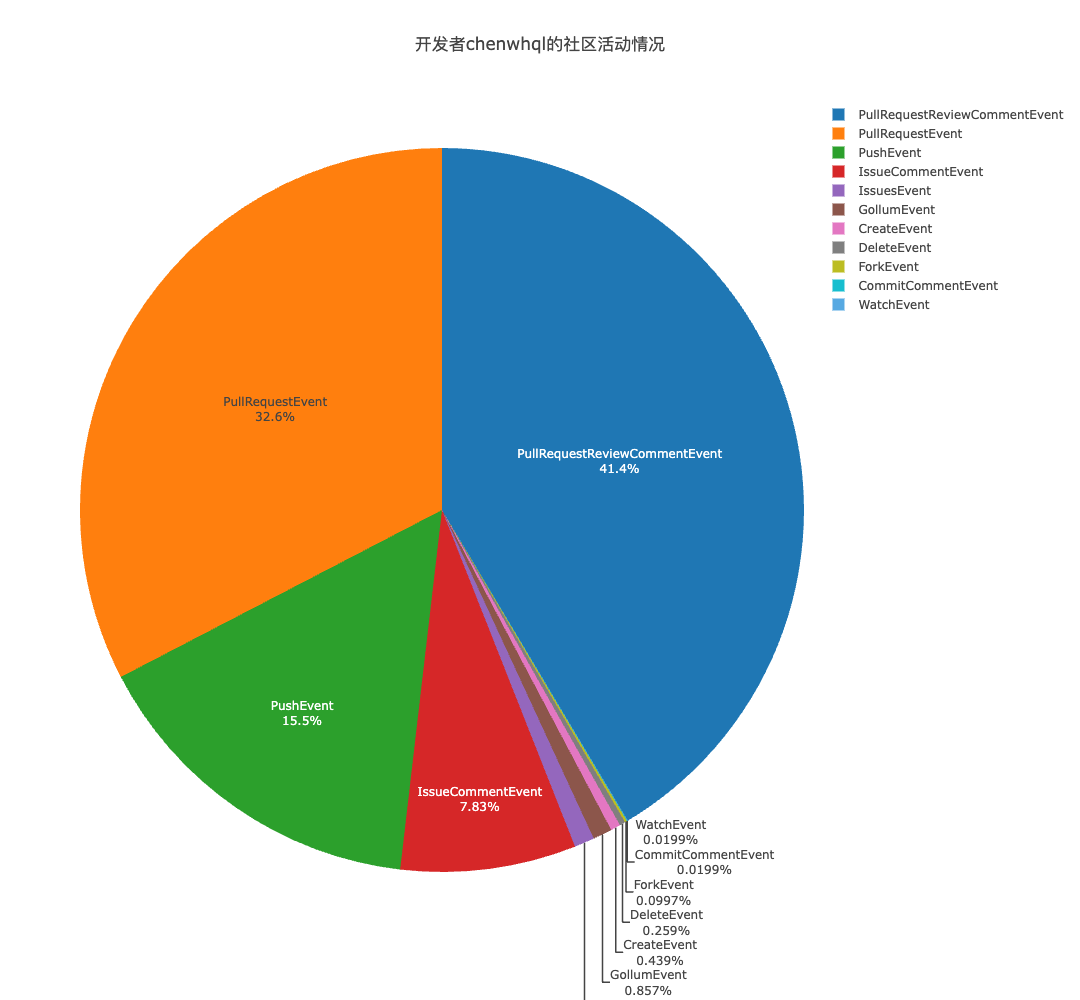

In [33]:
//issue数量、issue_comment、PR、PR_ReviewComment的占比
query(    
    `
        select type,count() as cnt
        from github_log.events 
        where actor_login = 'chenwhql'
        --where actor_login = 'chenwhql' and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewCommentEvent')
        group by type 
    `
).then(data => {
    var types=[],cnts= [];
    data.forEach(d => {
        types.push(d.type);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: types, values: cnts, type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者chenwhql的社区活动情况',
        xaxis: {type: 'category'},
        height: 1000,
    });
});

开发者chenwhql的PullRequestReviewComment占比为41.4%、而PullRequest超过30%，说明其目前的定位是社区的维护者，有接近一半的活动是在帮助其他开发者进行代码核查，同时开发者chenwhql自己也经常进行代码作业，积极提交PR

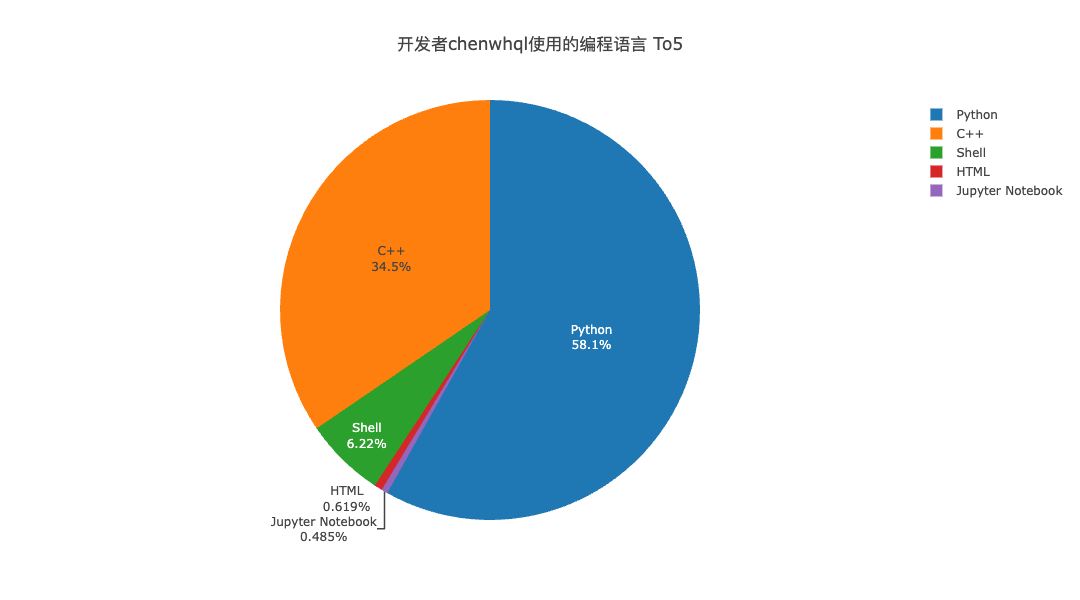

In [34]:
//使用的编程语言
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != '' and actor_login = 'chenwhql'
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者chenwhql使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者chenwhql习惯使用的编程语言是Python，然后是C++

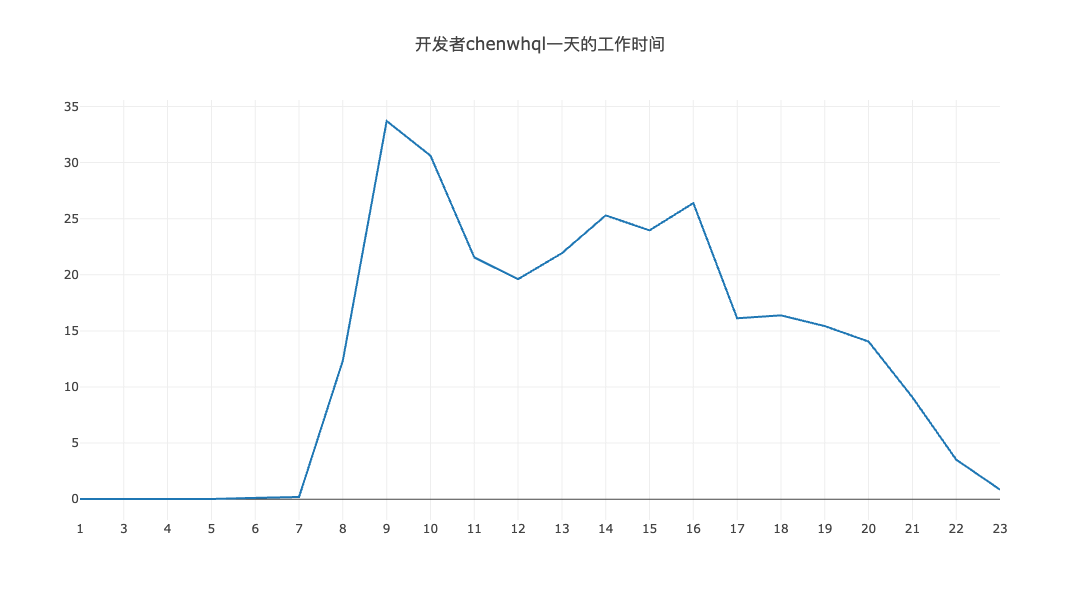

In [35]:
//工作时间（'chenwhql'所在的时区为7）
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
        where actor_login = 'chenwhql'
    ) AS total_times
     select (toHour(created_at)+7) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events 
     where actor_login = 'luotao1'
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者chenwhql一天的工作时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者chenwhql一天的工作时间是从早上8点到晚上9点，并在早上9点达到一个高峰

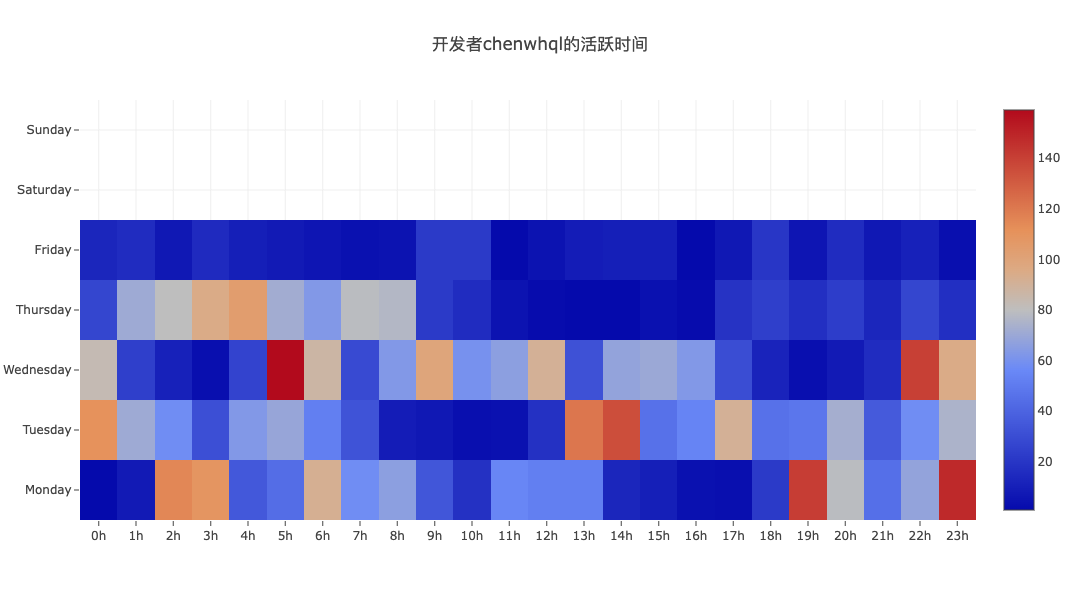

In [36]:
//活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(toHour(created_at)+7)%24 as hour,count() as times
     from github_log.events
     where actor_login = 'chenwhql'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['0h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: '开发者chenwhql的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者chenwhql主要是在工作日进行社区活动，周末没有进行任何社区活动

#### 2.3.6 开发者typhoonzero

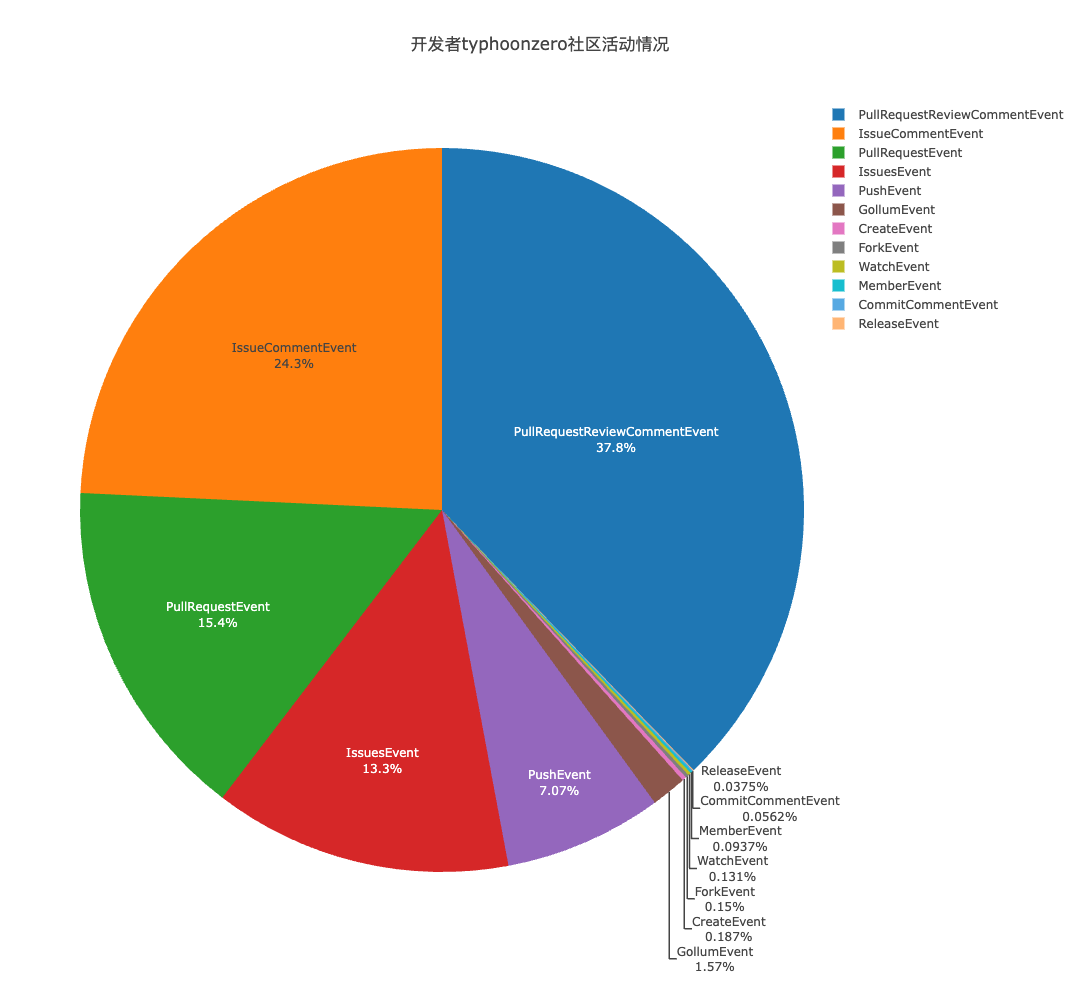

In [37]:
//issue数量、issue_comment、PR、PR_ReviewComment的占比
query(    
    `
        select type,count() as cnt
        from github_log.events 
        where actor_login = 'typhoonzero'
        --where actor_login = 'typhoonzero' and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewCommentEvent')
        group by type 
    `
).then(data => {
    var types=[],cnts= [];
    data.forEach(d => {
        types.push(d.type);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: types, values: cnts, type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者typhoonzero社区活动情况',
        xaxis: {type: 'category'},
        height: 1000,
    });
});

开发者typhoonzero的PullRequestReviewComment占比为37.8%、而IssueComment超过24.3%，说明其目前的定位是社区的维护者，积极解答其他开发者的问题并进行代码审查

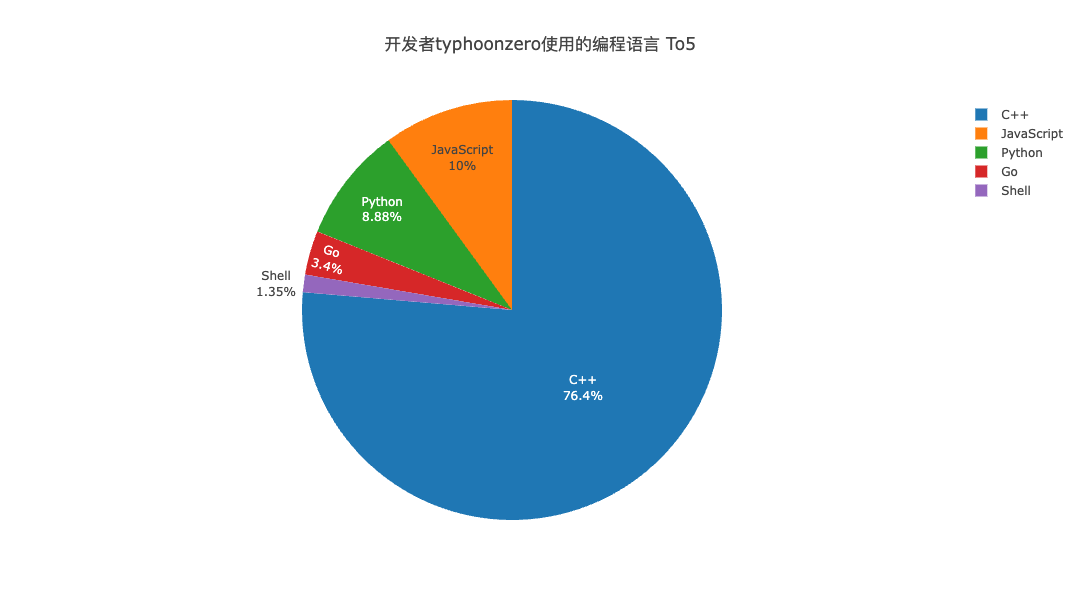

In [38]:
//使用的编程语言
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != '' and actor_login = 'typhoonzero'
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者typhoonzero使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者typhoonzero使用的编程语言主要是C++，超过76.4%

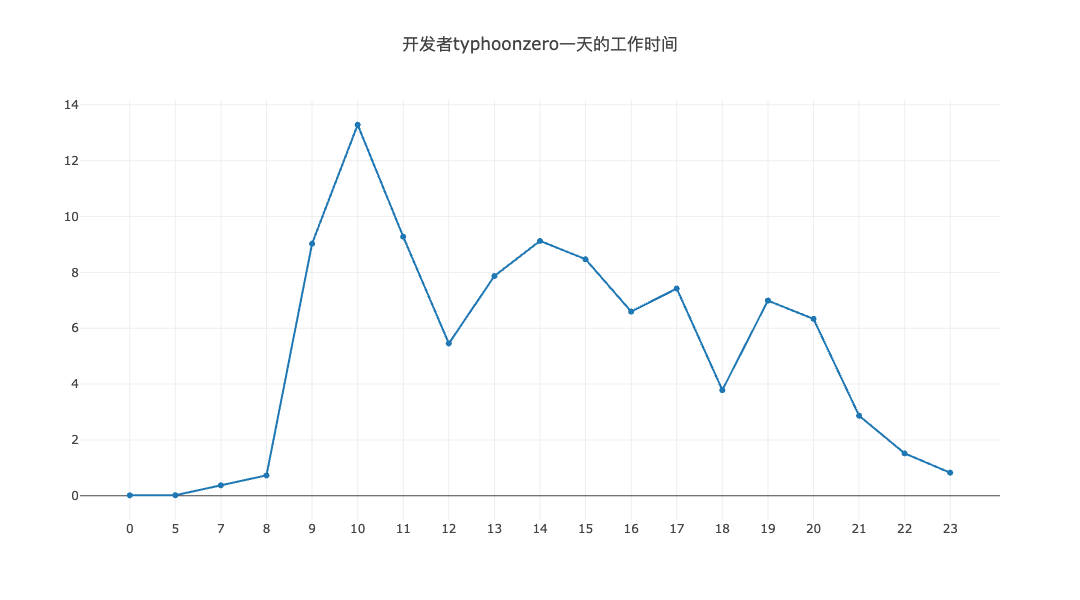

In [39]:
//工作时间（'typhoonzero'所在的时区为8）
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
        where actor_login = 'typhoonzero'
    ) AS total_times
     select (toHour(created_at)+8) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events 
     where actor_login = 'typhoonzero'
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者typhoonzero一天的工作时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者typhoonzero的主要工作时间是从早上9点到晚上8点，并在早上10点达到全天的高峰

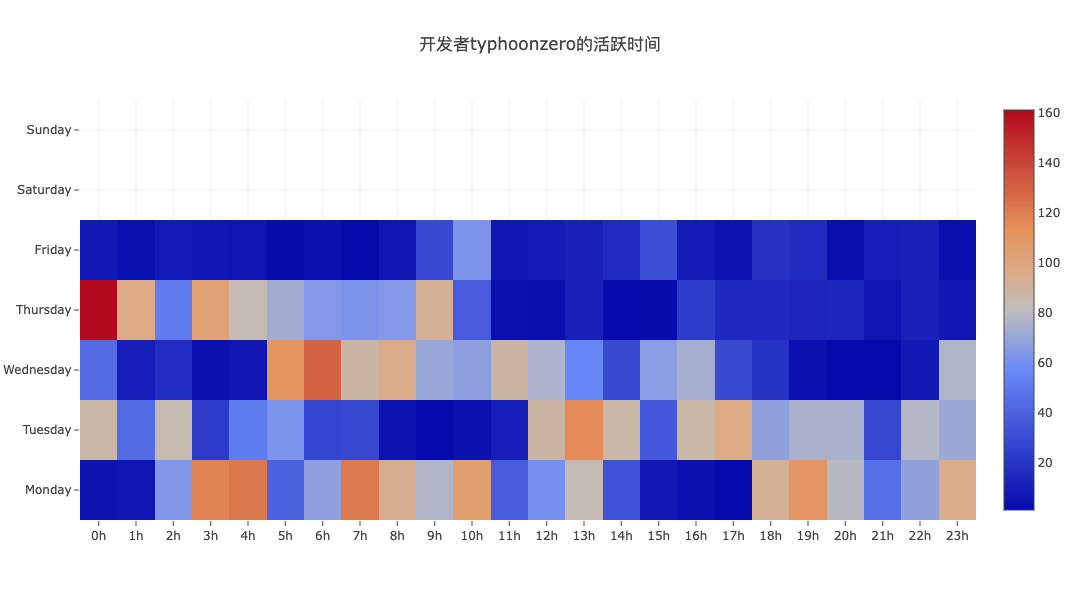

In [40]:
//活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(toHour(created_at)+8)%24 as hour,count() as times
     from github_log.events
     where actor_login = 'typhoonzero'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['0h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: '开发者typhoonzero的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者typhoonzero主要是在工作日进行社区活动，其周末不进行任何的社区活动

#### 2.3.7 开发者TCChenlong

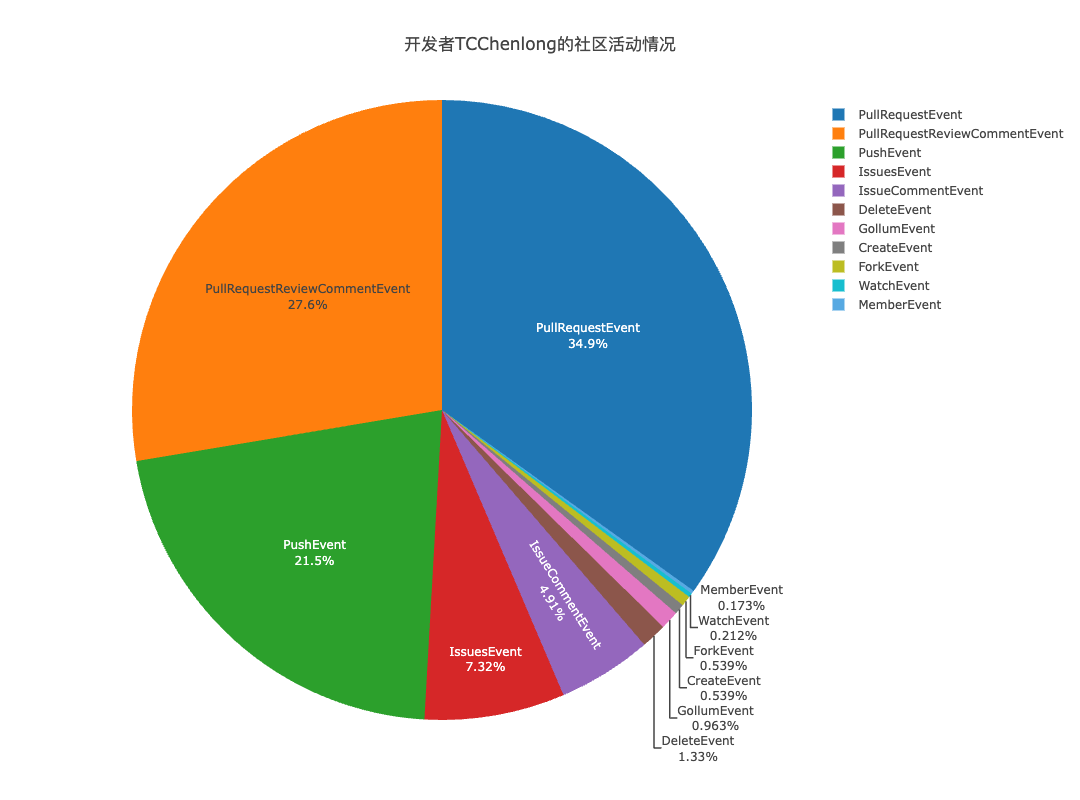

In [41]:
//issue数量、issue_comment、PR、PR_ReviewComment的占比
query(    
    `
        select type,count() as cnt
        from github_log.events 
        where actor_login = 'TCChenlong'
        --where actor_login = 'TCChenlong' and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewCommentEvent')
        group by type 
    `
).then(data => {
    var types=[],cnts= [];
    data.forEach(d => {
        types.push(d.type);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: types, values: cnts, type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者TCChenlong的社区活动情况',
        xaxis: {type: 'category'},
        height: 800,
    });
});

开发者TCChenlong的PR相关的活动之和超过了85%，而Issue相关的活动比较少，说明该开发者更喜欢代码相关的活动，积极提交PR和帮助社区进行代码审查

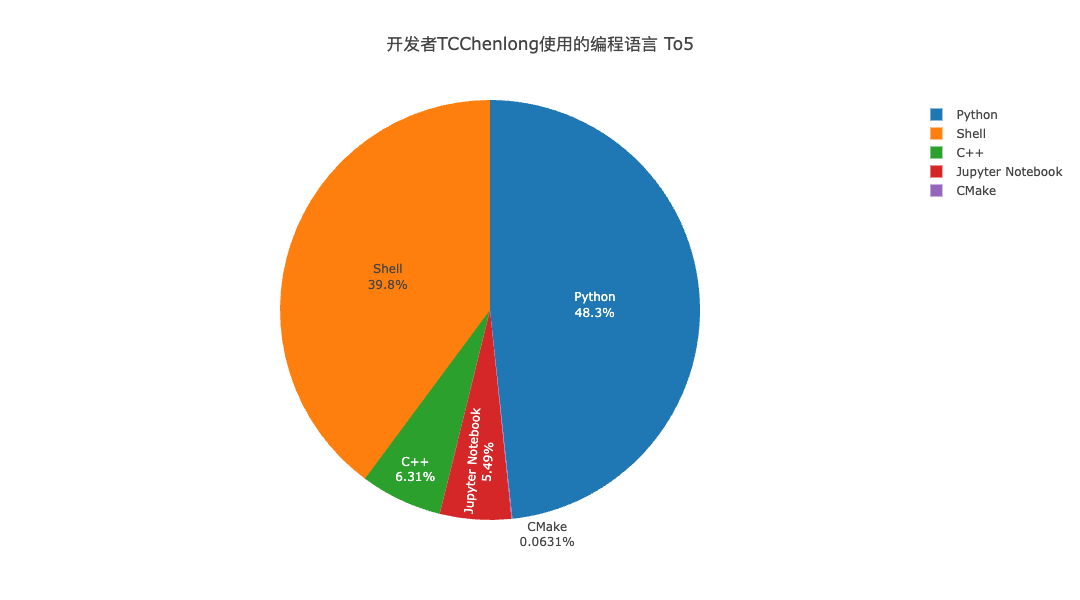

In [42]:
//使用的编程语言
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != '' and actor_login = 'TCChenlong'
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者TCChenlong使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者TCChenlong主要使用的编程是Python，占比接近50%，其次是Shell，占比也达到39.8%

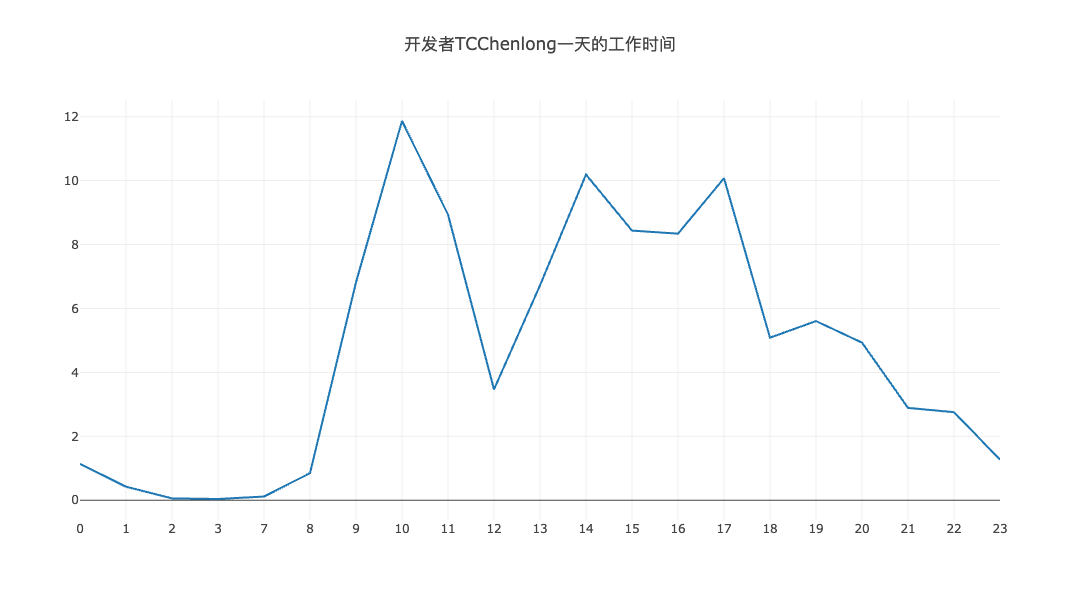

In [43]:
//工作时间（'TCChenlong'所在的时区为8）
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
        where actor_login = 'TCChenlong'
    ) AS total_times
     select (toHour(created_at)+8) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events 
     where actor_login = 'TCChenlong'
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者TCChenlong一天的工作时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者TCChenlong一天的哦给你做时间主要集中在9点到晚上8点，并在早上10点达到一天的高峰

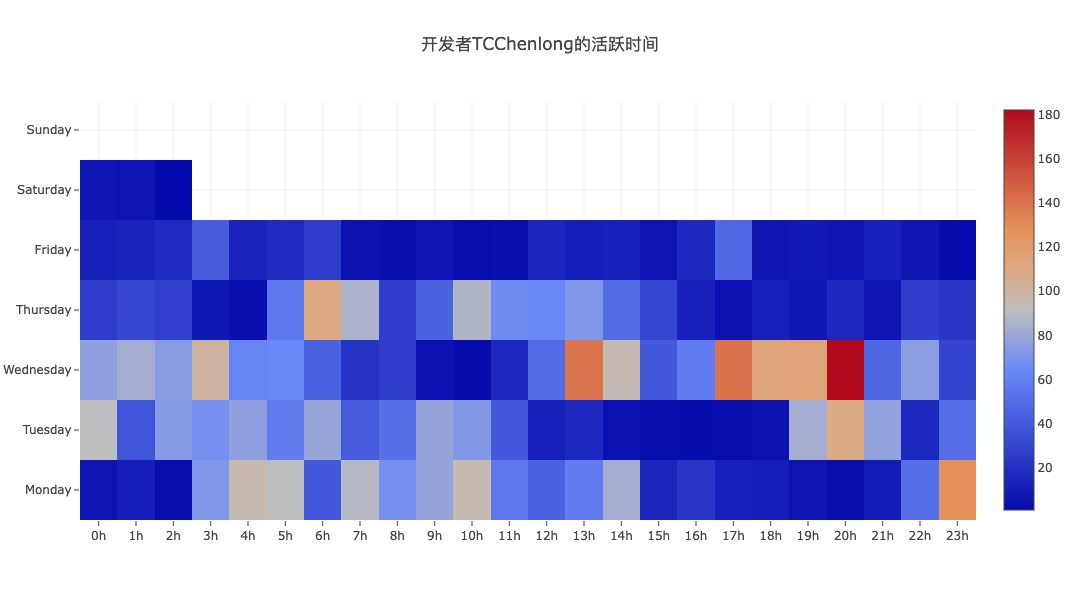

In [45]:
//活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(toHour(created_at)+8)%24 as hour,count() as times
     from github_log.events
     where actor_login = 'TCChenlong'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['0h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: '开发者TCChenlong的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者TCChenlong主要是在工作日进行社区活动，周末基本不进行活动

#### 2.3.8 开发者gongweibao

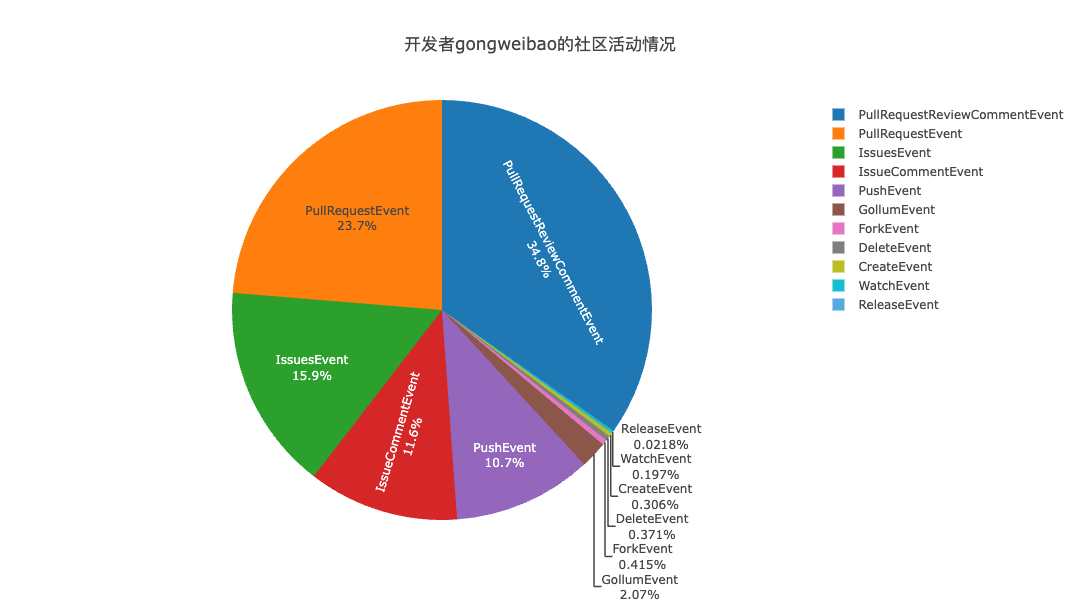

In [45]:
//issue数量、issue_comment、PR、PR_ReviewComment的占比
query(    
    `
        select type,count() as cnt
        from github_log.events 
        where actor_login = 'gongweibao'
        --where actor_login = 'gongweibao' and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewCommentEvent')
        group by type 
    `
).then(data => {
    var types=[],cnts= [];
    data.forEach(d => {
        types.push(d.type);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: types, values: cnts, type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者gongweibao的社区活动情况',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者gongweibao的PR相关的活动之和超过了75%，说明该开发者更喜欢代码相关的活动，积极提交PR和帮助社区进行代码审查

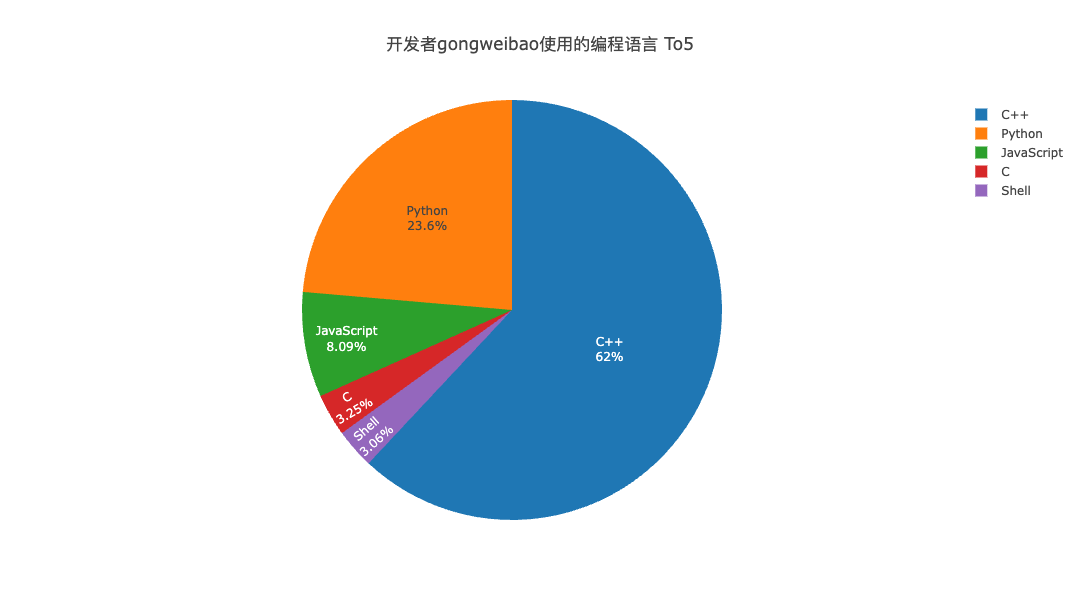

In [46]:
//使用的编程语言
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != '' and actor_login = 'gongweibao'
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者gongweibao使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者gongweibao主要使用C++，占比为62%，其次是Python，占比为23.6%

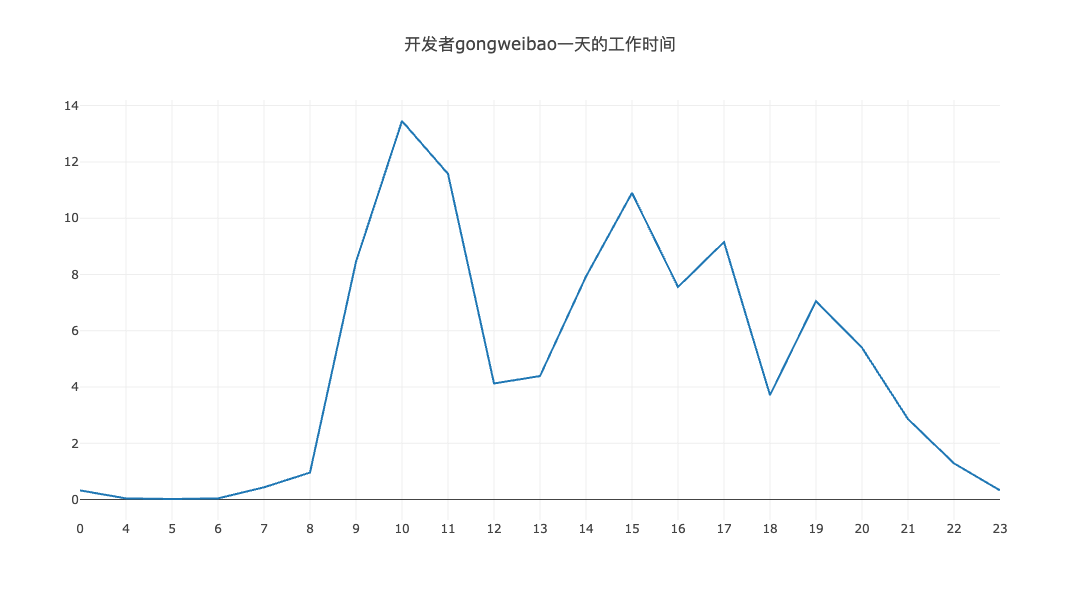

In [48]:
//工作时间（'gongweibao'所在的时区为8）
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
        where actor_login = 'gongweibao'
    ) AS total_times
     select (toHour(created_at)+8) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events 
     where actor_login = 'gongweibao'
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者gongweibao一天的工作时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者gongweibao的主要工作时间是早上9点到晚上8点，且在早上10点达到一天的高峰

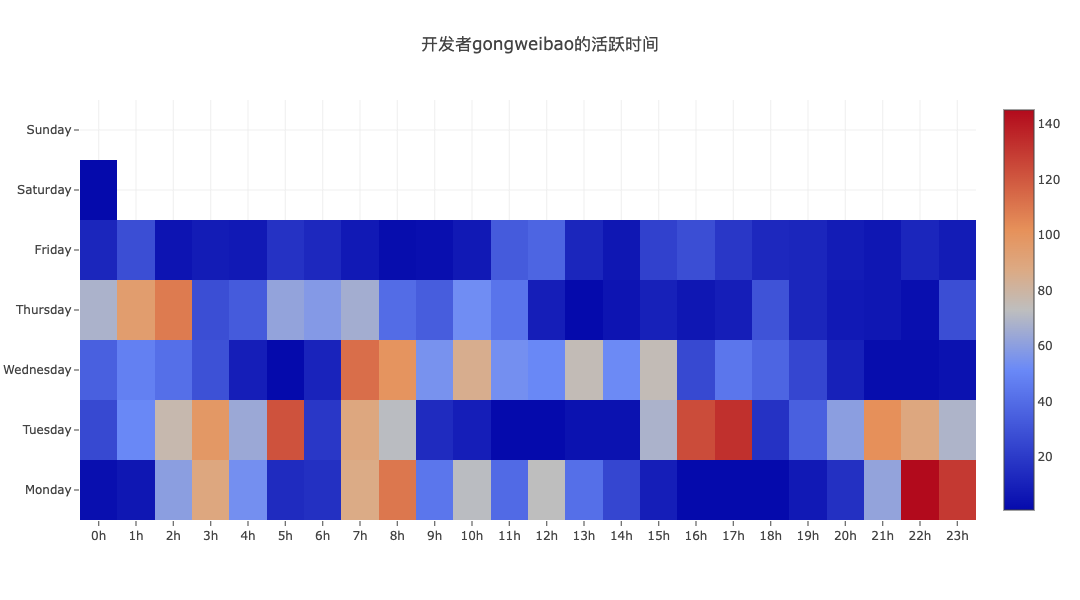

In [49]:
//活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(toHour(created_at)+8)%24 as hour,count() as times
     from github_log.events
     where actor_login = 'gongweibao'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['0h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: '开发者gongweibao的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者gongweibao主要是在工作日进行社区活动

#### 2.3.9 开发者littletomatodonkey

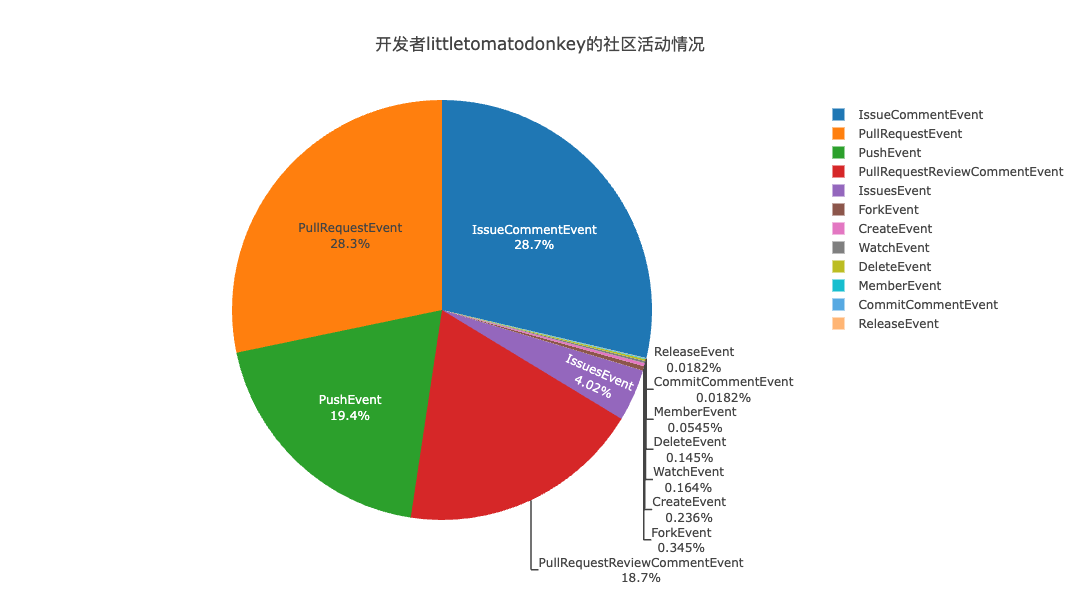

In [49]:
//issue数量、issue_comment、PR、PR_ReviewComment的占比
query(    
    `
        select type,count() as cnt
        from github_log.events 
        where actor_login = 'littletomatodonkey'
        --where actor_login = 'littletomatodonkey' and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewCommentEvent')
        group by type 
    `
).then(data => {
    var types=[],cnts= [];
    data.forEach(d => {
        types.push(d.type);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: types, values: cnts, type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者littletomatodonkey的社区活动情况',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者littletomatodonkey的PR相关的活动超过50%，同时其IssueComment也占到28.7%，说明其在积极提交PR和帮助社区进行代码审查的同时也积极帮助其他开发者解答疑惑

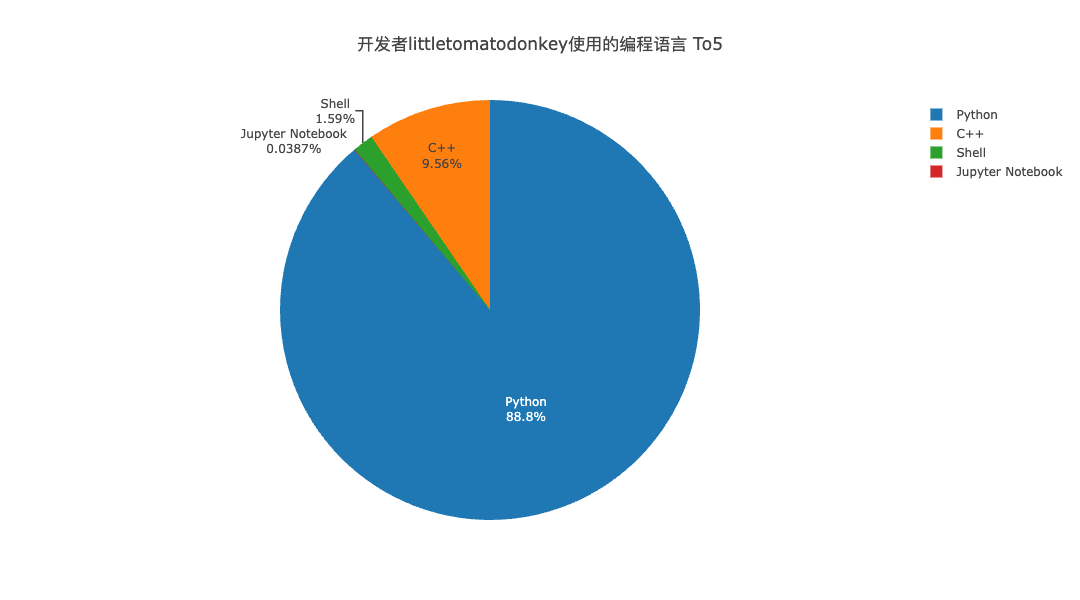

In [51]:
//使用的编程语言
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != '' and actor_login = 'littletomatodonkey'
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者littletomatodonkey使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者littletomatodonkey习惯使用的编程语言是Python,占比为88.85

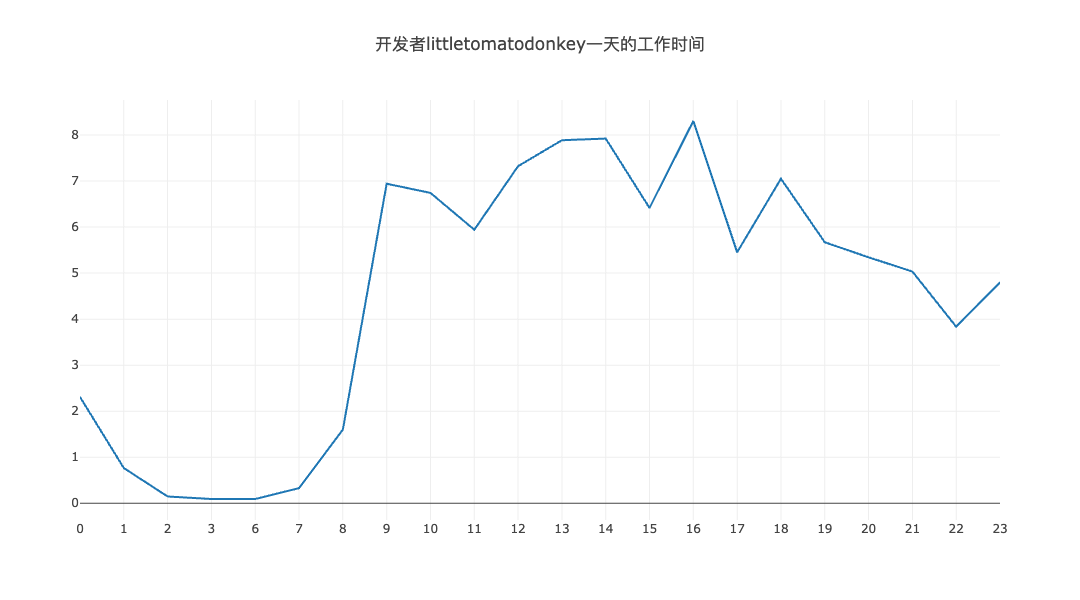

In [51]:
//工作时间（'littletomatodonkey'所在的时区为7）
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
        where actor_login = 'littletomatodonkey'
    ) AS total_times
     select (toHour(created_at)+7) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events 
     where actor_login = 'littletomatodonkey'
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者littletomatodonkey一天的工作时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者littletomatodonkey一天的主要工作时间是早上9点到晚上10点，并在下午4点达到一天的高峰，其凌晨1点也有活动

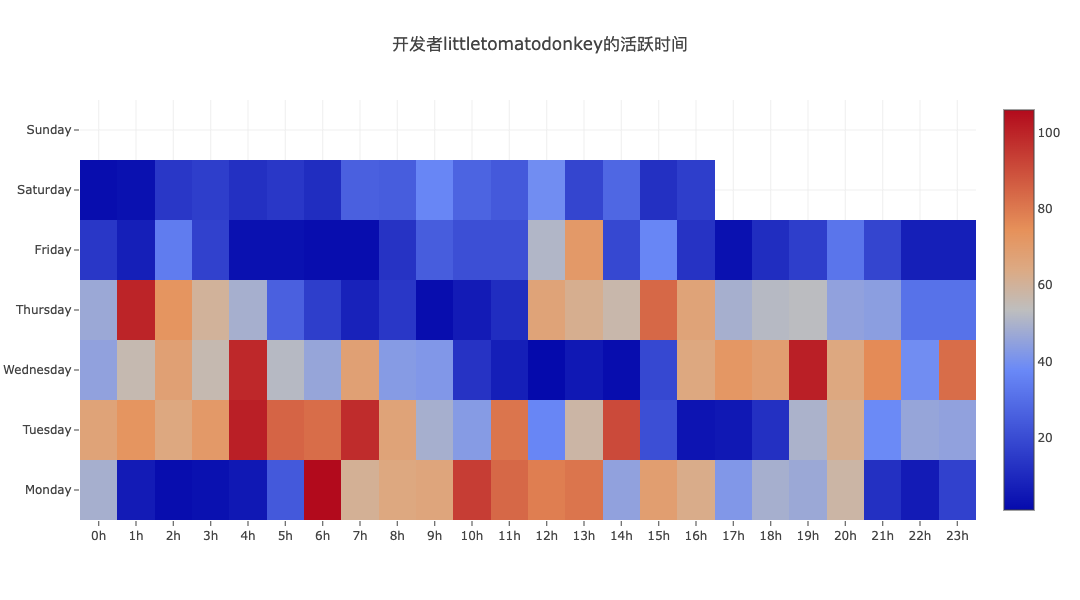

In [52]:
//活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(toHour(created_at)+7)%24 as hour,count() as times
     from github_log.events
     where actor_login = 'littletomatodonkey'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['0h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: '开发者littletomatodonkey的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者littletomatodonkey活跃时间是周一到周六

#### 2.3.10 开发者wangkuiyi

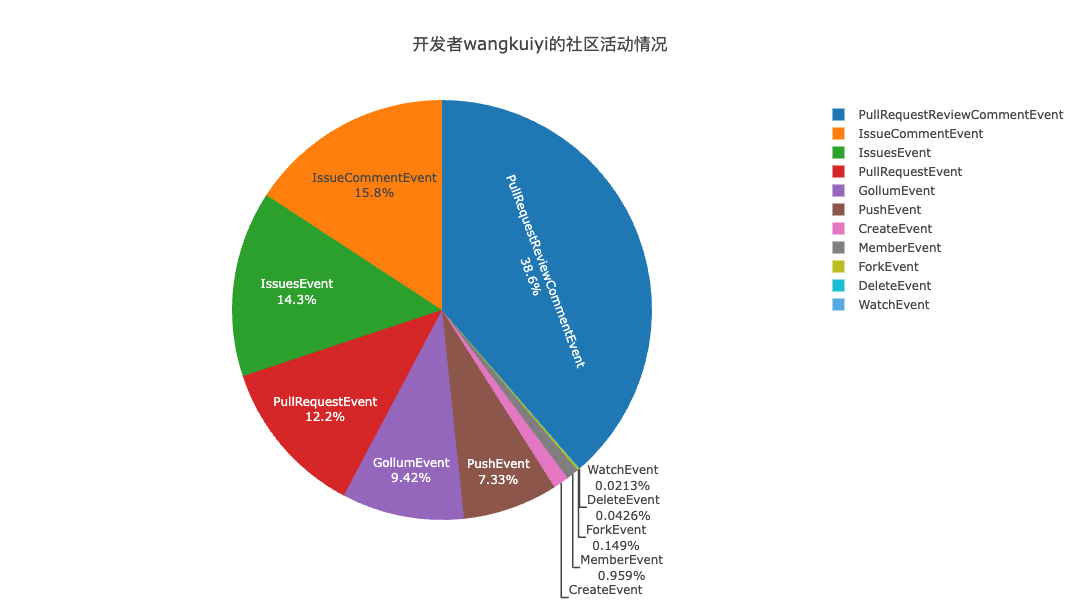

In [53]:
//issue数量、issue_comment、PR、PR_ReviewComment的占比
query(    
    `
        select type,count() as cnt
        from github_log.events 
        where actor_login = 'wangkuiyi'
        --where actor_login = 'wangkuiyi' and type in ('IssuesEvent','IssueCommentEvent','PullRequestEvent','PullRequestReviewCommentEvent')
        group by type 
    `
).then(data => {
    var types=[],cnts= [];
    data.forEach(d => {
        types.push(d.type);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: types, values: cnts, type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者wangkuiyi的社区活动情况',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者wangkuiyi主要进行的活动是PullRequestReviewComment，占比为38.6%，说明其主要帮助社区进行代码审查的

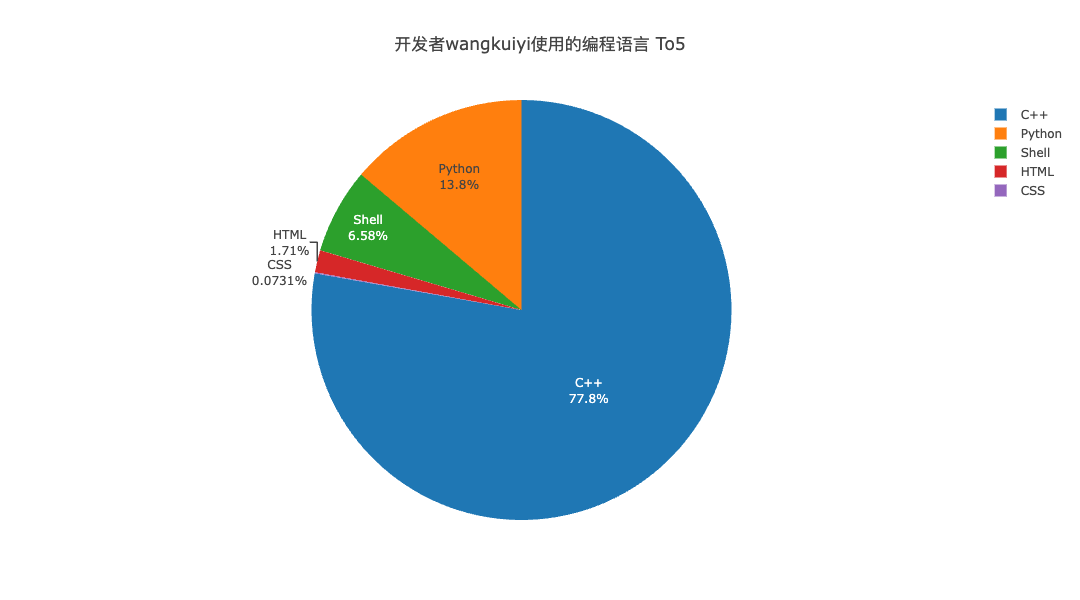

In [54]:
//使用的编程语言
query(    
    `select distinct repo_language,count(*) as cnt
     from github_log.events
     where repo_language != '' and actor_login = 'luotao1'
     group by repo_language
     order by cnt desc
     limit 5
     `
).then(data => {
    var repo_languages=[],cnts= [];
    data.forEach(d => {
        repo_languages.push(d.repo_language);
        cnts.push(d.cnt);
    });

openDigger.render.plotly([
    {labels: repo_languages, values: cnts,type:'pie', name: '数量', textinfo: "label+percent",}], 
    {
        title: '开发者wangkuiyi使用的编程语言 To5',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者wangkuiyi主要使用的编程语言是C++，占比为77.8%，其次是Python

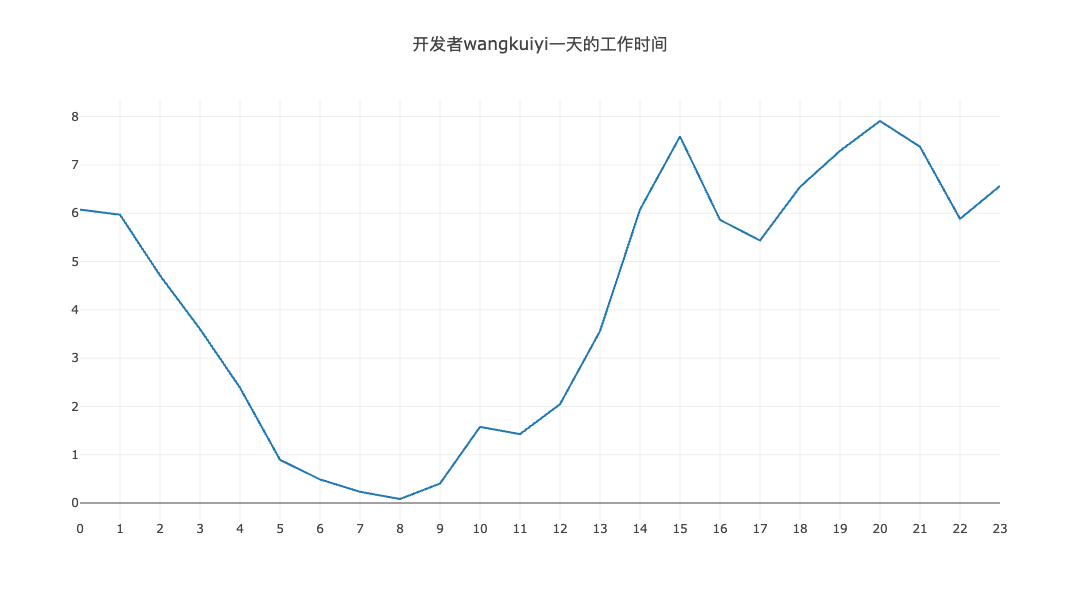

In [55]:
//工作时间（'wangkuiyi'所在的时区为-3）
query(    
    `WITH
    (
        SELECT count() 
        FROM github_log.events
        where actor_login = 'wangkuiyi'
    ) AS total_times
     select (24+toHour(created_at) -3) % 24 as hour,(count() / total_times)*100 as propotion
     from github_log.events 
     where actor_login = 'wangkuiyi'
     group by hour
     order by hour
    `
).then(data => {
    var hours=[],propotion = [];
    data.forEach(d => {
        hours.push(d.hour);
        propotion.push(d.propotion);
    });

openDigger.render.plotly([
    {x: hours, y: propotion, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: '开发者wangkuiyi一天的工作时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者wangkuiyi一天的除了早上5点到早上9点，其他时间都是他的工作时间

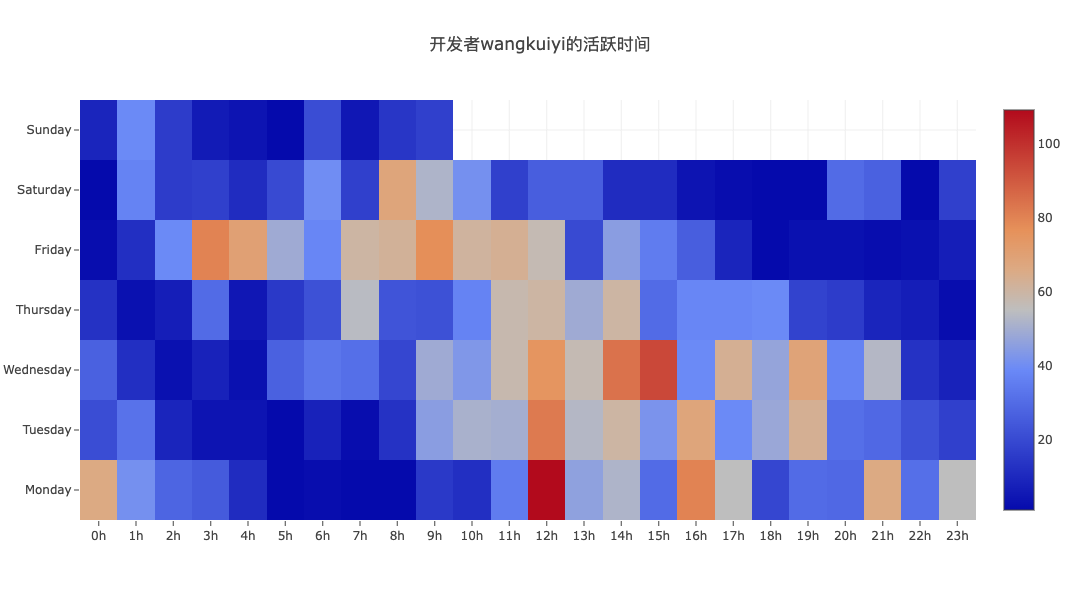

In [56]:
//活跃时间
query(    
    `select toDayOfWeek(created_at) as week,(24 + toHour(created_at) -3) % 24 as hour,count() as times
     from github_log.events
     where actor_login = 'wangkuiyi'
     group by week,hour
     order by week,hour
    `
).then(data => {
    var week=[],hour= [],time=[],temp=[];
    var t = 0;
    data.forEach(d => {
        if(t == 24)
        {
            time.push(temp);
            temp=[];
            t = 0;
        }
        week.push(d.week);
        hour.push(d.hour);
        temp.push(d.times);
        t++
    });
    time.push(temp);
    //console.log(time);

openDigger.render.plotly([
    {z: time,
     x: ['0h', '1h', '2h','3h','4h','5h','6h','7h','8h','9h','10h','11h','12h','13h','14h','15h','16h','17h','18h','19h','20h','21h','22h','23h'],
     y: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'],
     type: 'heatmap',
     hoverongaps: false
    }], 
    {
        title: '开发者wangkuiyi的活跃时间',
        xaxis: {type: 'category'},
        height: 600,
    });
});

开发者wangkuiyi的活跃时间的活跃时间是周一到周六，周日只在晚上12点到第二天的早上9点进行社区活动